# Ordinary Differential Equation Solver "Odie:" Examples

## Authors: Gabriel M Steward

### May 2023

### </list_source_code> NRPy+ Source Code for this module:
[cmdline_helper.py](/edit/cmdline_helper.py) (Multiplatform command line interface) 

[outputC.py](/edit/outputC.py) (NRPy+ code for packaging and compiling C)

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb (template for using outputC.py)

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Solving_the_Scalar_Wave_Equation_with_NumPy.ipynb (basic Python plotting code)

(All of this will need to be adjusted when properly inside the actual nrpytutorial repository). 

## Introduction:
Welcome to the Ordinary Differential Equation Solver Tutorial Examples notebook, wherin we will showcase a program that solves Ordinary Differential Equations with the intent of helping users see different ways to use it. 

This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a system of Ordinary Differential Equations (ODEs) with initial boundary conditions and solves it numerically. There are many ways to implement the code, but the primary method shown here produces a text file with the previously unknown functions' values at various sequential points. More details can be found about the technicalities behind Odie's operation in the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook (for new users) and [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook (for a deep dive). It is recommended that users look at the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook for context by which to understand this one. 

This notebook has two primary parts: the Simple Example, [Step 2](#S2), and the Complicated Example, [Step 3](#S3), which showcase two ways of using Odie to solve Systems of Differential Equations. 

### Citations:

<a id='1'></a>
[5] https://www.dataquest.io/blog/read-file-python/ (Opening and reading CSV files)

<a id='2'></a>
[6] https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib (Changing size of plot)

<a id='3'></a>
[7] https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine (how to move up out of a Python directory)


<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Compiling Code

3. [Step 2:](#S2) Simple Problem Example

    1. [Step 2a:](#S2a) Simple Problem Customization

    5. [Step 2b:](#S2b) Simple Problem Code Compilation

    6. [Step 2c:](#S2c) Simple Problem Results
    
    6. [Step 2d:](#S2d) Simple Problem Analysis
        
    6. [Step 2e:](#S2e) Multiple Run Examination
    
7. [Step 3:](#S3) Complicated Problem Example

    1. [Step 3a:](#S3a) Complicated Problem Customization

    4. [Step 3b:](#S3b) Complicated Problem Code Compliation

    6. [Step 3c:](#S3c) Complicated Problem Results
    
    6. [Step 3d:](#S3d) Complicated Problem Analysis
    
    6. [Step 3e:](#S3e) Complicated Problem Extension: Adams Bashforth and Hybrid Methods

8. [Step 4:](#S4) Conclusion

8. [Step 5:](#S5) Questions/Exercies

9. [Step 6:](#S6) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Compiling Code \[Back to [top](#toc)\]
$$\label{S1}$$

#### The program needs to exist to run

This section, while visually long, has essentially nothing for the user to look at. The notebook just compiles all the files it needs in these next few cells. Make sure to run them all before running the rest of the notebook. 

Users that wish to know specifics of what the code is doing should invistigate the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) and [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebooks as required. 

In order to run Odie, which is a C-code, from within this Python-based jupyter notebook, we will need to rely on NRPy+'s C-code generation libraries. This notebook, while it is a tutorial, is not concerned with explaining the ins and outs of how to do this; that can be found in the various [nrpytutorial notebooks](https://github.com/zachetienne/nrpytutorial). (NOTE: If this is in nrpytutorial this link is probably unecessary). 

In [1]:
import outputC as outC       # NRPy+: Core C code output module.
import cmdline_helper as cmd # NRPy+: Multi-platform Python command-line interface
import os                    # Python: Miscellaneous operating system interfaces
import shutil                # Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

# Create a C code output directory
# First, name it.
Ccodesrootdir = os.path.join("nrpy_odiegm_notebook_codes/")
# Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
# Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

In [2]:
nrpy_odiegm_h = r"""  

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// Note: math.h requries the "-lm" arg be added at the END of tasks.json's arguments.
// https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

// ODE Solver "Odie"
// By G. M. Steward
// The main goal of this project is to solve Ordinary Differential Equation Systems
// in complete generality.
// This tenth version seeks to make this code functional as a drop-in replacement for GSL's solver. 

// Heavily influenced by Numerical Mathematics and Computing 6E by Cheney and Kincaid
// and GSL's ODE Solver, especially the method for adaptive time step and high-level funcitonality. 

// https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRTEOBResumS.c
// Lalsuite section for what parts of GSL this was designed to replace. 

// This is the header file for Odie. 
// It contains the structure definitions. 
// The structs are defined below largely in accordance with GSL definitions. 
// However, unecessary variables were removed, and many new ones were added. 
// Butcher tables can be found at the bottom of this file. 
// Function prototypes can be found in nrpy_odiegm_proto.c


typedef struct {
    int (*function) (double x, double y[], double dydx[], void *params);
    // The function passed to this struct contains the definitions of the differnetial equations. 
    // int (*jacobian) (double t, const double y[], double *dfdy, double dfdt[], void *params); 
    // The Jacobian was a holdover from GSL, it will not be used in this program.
    int (*true_function) (double x, double y[]);
    // INSTEAD we will use the Jacobian's slot slot to allow passing of a true value! 
    // Naturally, this is only used if desired.
    size_t dimension; //For storing how big our system of equations is. 
    // Just pass it an int, usually. 
    void *params; // For storing extra constants needed to evaluate the functions. 
    // params->dimension stores how many there are. 
    // Struct definition can be found in nrpy_odiegm_user_methods.c
} nrpy_odiegm_system;


typedef struct {
    // Unlike with the system struct above, this step_type struct does not need
    // to match GSL's form explicitly, it just needs to define the method.
    int rows; 
    int columns; // Size of table for used method.
    // Since we're dealing with void pointers we need a way to know how big everything is. 
    int order; // record the order.
    // These are set at the bottom of this file. 
    void *butcher;
    // Make sure to put this at the end of the struct
    // in case we add more parts to it. Nonspecific arrays must be the last element.

    //Two of these step_type "objects" might be needed at once, depending on implementation. 
    //Fortunately you can make as many as you want. 
} nrpy_odiegm_step_type;


typedef struct {
  const nrpy_odiegm_step_type *type; 
  int rows; 
  int columns; // Since we are passing a void pointer to do this, we need a way
  // to know how large it is in the end.
  // Purposefully redundant with step_type's rows and columns value. 
  int method_type; // What type of method we are using? 0,1,2 values. 
  int adams_bashforth_order; // Order if an AB method is used.
  void *y_values; // The extremely funky parameter that hides a 2D array, used when
  // the past steps are important for AB method.  
  // Stored in step struct since it needs access to adams_bashforth_order for allocation.
} nrpy_odiegm_step;

typedef struct {
    // Various error parameters
    double abs_lim; // Absolute error limiter
    double rel_lim; // Relative error limiter
    double scale_factor; // A scale factor used in the error comparison formula.
    double error_safety; // A factor that limits how drastically things can change for stability.
    double ay_error_scaler; // Weight given to error estimates related to the function itself.
    double ady_error_scaler; // Weight given to error estimates related to the function's derivative.
    double max_step_adjustment; // What is the largest growing step adjustment we'll allow?
    double min_step_adjustment; // What is the smallest shrinking step adjustment we'll allow?
    double absolute_max_step; // Largest allowed step?
    double absolute_min_step; // Smallest allowed step?
    double error_upper_tolerance; // If estimated error is higher than this, it is too high. 
    double error_lower_tolerance; // If estimated error is lower than this, it is too low.
    // We added these ourselves. Control the error!
    // We suppose this means that our control struct acts NOTHING like GSL's control struct
    // save that it stores error limits. 
} nrpy_odiegm_control;

typedef struct
{
  double *y0; // The values of the system of equations
  double *yerr; // The estimated errors, if needed 
  double last_step; // Set to 1 when we are at the last step.
  // Probably not used but the user may want it for some reason. 
  // Could be used as a termination condition. 
  double bound; // The point at which we started is sometimes important. 
  double current_position; // It's a good idea to know where we are at any given time. 
  unsigned long int count; // Equivalent to i. Keeps track of steps taken.
  bool no_adaptive_step; // A simple toggle for forcing the steps to be the same or not.
} nrpy_odiegm_evolve;



typedef struct {
    const nrpy_odiegm_system *sys; // ODE system 
    nrpy_odiegm_evolve *e;         // evolve struct 
    nrpy_odiegm_control *c;         // control struct 
    nrpy_odiegm_step *s;          // step struct, will contain step type 
    double h;                     // step size 
    // Curiously, this is where the step size is held. 
    // Usually it's passed to functions directly though. 
} nrpy_odiegm_driver;



// A collection of butcher tables, courtesy of NRPy+.
// This section just has definitions. 
// Specifically of all the various kinds of stepper methods we have on offer. 

double butcher_Euler[2][2] = {{0.0,0.0},{1.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_euler0 = {2,2,1,&butcher_Euler};
const nrpy_odiegm_step_type *nrpy_odiegm_step_euler = &nrpy_odiegm_step_euler0;

double butcher_RK2H[3][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_Heun0 = {3,3,2,&butcher_RK2H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Heun = &nrpy_odiegm_step_RK2_Heun0;

double butcher_RK2MP[3][3] = {{0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0},{2.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_MP0 = {3,3,2,&butcher_RK2MP};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_MP = &nrpy_odiegm_step_RK2_MP0;

double butcher_RK2R[3][3] = {{0.0,0.0,0.0},{2.0/3.0,2.0/3.0,0.0},{2.0,1.0/4.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_R0 = {3,3,2,&butcher_RK2R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Ralston = &nrpy_odiegm_step_RK2_R0;

double butcher_RK3[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{1.0,-1.0,2.0,0.0},{3.0,1.0/6.0,2.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_0 = {4,4,3,&butcher_RK3};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3 = &nrpy_odiegm_step_RK3_0;

double butcher_RK3H[4][4] = {{0.0,0.0,0.0,0.0},{1.0/3.0,1.0/3.0,0.0,0.0},{2.0/3.0,0.0,2.0/3.0,0.0},{3.0,1.0/4.0,0.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_H0 = {4,4,3,&butcher_RK3H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Heun = &nrpy_odiegm_step_RK3_H0;

double butcher_RK3R[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_R0 = {4,4,3,&butcher_RK3R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Ralston = &nrpy_odiegm_step_RK3_R0;

double butcher_RK3S[4][4] = {{0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0},{1.0/2.0,1.0/4.0,1.0/4.0,0.0},{3.0,1.0/6.0,1.0/6.0,2.0/3.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_S0 = {4,4,3,&butcher_RK3S};
const nrpy_odiegm_step_type *nrpy_odiegm_step_SSPRK3 = &nrpy_odiegm_step_RK3_S0;

double butcher_RK4[5][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{1.0/2.0,0.0,1.0/2.0,0.0,0.0},{1.0,0.0,0.0,1.0,0.0},{4.0,1.0/6.0,1.0/3.0,1.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK4_0 = {5,5,4,&butcher_RK4};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK4 = &nrpy_odiegm_step_RK4_0;
// This alternate name is declared for gsl drop in requirements. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk4 = &nrpy_odiegm_step_RK4_0;

double butcher_DP5[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5_0 = {8,8,5,&butcher_DP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5 = &nrpy_odiegm_step_DP5_0;

double butcher_DP5A[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0},{5.0,821.0/10800.0,0.0,19683.0/71825.0,175273.0/912600.0,395.0/3672.0,785.0/2704.0,3.0/50.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5A_0 = {8,8,5,&butcher_DP5A};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5alt = &nrpy_odiegm_step_DP5A_0;

double butcher_CK5[7][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_CK5_0 = {7,7,5,&butcher_CK5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_CK5 = &nrpy_odiegm_step_CK5_0;

double butcher_DP6[9][9] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0,0.0},{1.0,465467.0/266112.0,-2945.0/1232.0,-5610201.0/14158144.0,10513573.0/3212352.0,-424325.0/205632.0,376225.0/454272.0,0.0,0.0},{6.0,61.0/864.0,0.0,98415.0/321776.0,16807.0/146016.0,1375.0/7344.0,1375.0/5408.0,-37.0/1120.0,1.0/10.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP6_0 = {9,9,6,&butcher_DP6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP6 = &nrpy_odiegm_step_DP6_0;

// This one is left in terms of floating points, as the form stored in 
// the butcher table includes irrational numbers and other stuff. 
// double butcher_L6[8][8] = {{0.0,0,0,0,0,0,0,0},{1.0,1.0,0,0,0,0,0,0},{0.5,0.375,0.125,0,0,0,0,0},{0.6666666666666666,0.2962962962962963,0.07407407407407407,0.2962962962962963,0,0,0,0},{0.17267316464601143,0.051640768506639186,-0.04933518989886041,0.2960111393931624,-0.1256435533549298,0,0,0},{0.8273268353539885,-1.1854881643947648,-0.2363790958154253,-0.7481756236662596,0.8808545802392703,2.116515138991168,0,0},{1.0,4.50650248872424,0.6666666666666666,6.017339969931307,-4.111704479703632,-7.018914097580199,0.9401094519616178,0},{6.0,0.05,0.0,0.35555555555555557,0.0,0.2722222222222222,0.2722222222222222,0.05}};
// const double sqrt21 = 4.58257569495584; //explicitly declared to avoid the funky problems with consts. 
// Manually added to the below definition since Visual Studio complained sqrt21 wasn't a constant.
double butcher_L6[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/2.0,3.0/8.0,1.0/8.0,0.0,0.0,0.0,0.0,0.0},{2.0/3.0,8.0/27.0,2.0/27.0,8.0/27.0,0.0,0.0,0.0,0.0},{1.0/2.0 - 4.58257569495584/14.0,-3.0/56.0 + 9.0*4.58257569495584/392.0,-1.0/7.0 + 4.58257569495584/49.0,6.0/7.0 - 6.0*4.58257569495584/49.0,-9.0/56.0 + 3.0*4.58257569495584/392.0,0.0,0.0,0.0},{4.58257569495584/14.0 + 1.0/2.0,-51.0*4.58257569495584/392.0 - 33.0/56.0,-1.0/7.0 - 4.58257569495584/49.0,-8.0*4.58257569495584/49.0,9.0/280.0 + 363.0*4.58257569495584/1960.0,4.58257569495584/5.0 + 6.0/5.0,0.0,0.0},{1.0,11.0/6.0 + 7.0*4.58257569495584/12.0,2.0/3.0,-10.0/9.0 + 14.0*4.58257569495584/9.0,7.0/10.0 - 21.0*4.58257569495584/20.0,-343.0/90.0 - 7.0*4.58257569495584/10.0,49.0/18.0 - 7.0*4.58257569495584/18.0,0.0},{6.0,1.0/20.0,0.0,16.0/45.0,0.0,49.0/180.0,49.0/180.0,1.0/20.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_L6_0 = {8,8,6,&butcher_L6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_L6 = &nrpy_odiegm_step_L6_0;

double butcher_DP8[14][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP8_0 = {14,14,8,&butcher_DP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP8 = &nrpy_odiegm_step_DP8_0;

// Adaptive Methods
double butcher_AHE[4][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0},{2.0,1.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AHE_0 = {4,3,2,&butcher_AHE};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AHE = &nrpy_odiegm_step_AHE_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk2 = &nrpy_odiegm_step_AHE_0;

double butcher_ABS[6][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0,0.0},{1.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,7.0/24.0,1.0/4.0,1.0/3.0,1.0/8.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ABS_0 = {6,5,3,&butcher_ABS};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ABS = &nrpy_odiegm_step_ABS_0;

double butcher_ARKF[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/4.0,1.0/4.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/32.0,9.0/32.0,0.0,0.0,0.0,0.0},{12.0/13.0,1932.0/2197.0,-7200.0/2197.0,7296.0/2197.0,0.0,0.0,0.0},{1.0,439.0/216.0,-8.0,3680.0/513.0,-845.0/4104.0,0.0,0.0},{1.0/2.0,-8.0/27.0,2.0,-3544.0/2565.0,1859.0/4104.0,-11.0/40.0,0.0},{5.0,16.0/135.0,0.0,6656.0/12825.0,28561.0/56430.0,-9.0/50.0,2.0/55.0},{5.0,25.0/216.0,0.0,1408.0/2565.0,2197.0/4104.0,-1.0/5.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ARKF_0 = {8,7,5,&butcher_ARKF};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ARKF = &nrpy_odiegm_step_ARKF_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkf45 = &nrpy_odiegm_step_ARKF_0;

double butcher_ACK[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0},{5.0,2825.0/27648.0,0.0,18575.0/48384.0,13525.0/55296.0,277.0/14336.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ACK_0 = {8,7,5,&butcher_ACK};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ACK = &nrpy_odiegm_step_ACK_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkck = &nrpy_odiegm_step_ACK_0;

double butcher_ADP5[9][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,5179.0/57600.0,0.0,7571.0/16695.0,393.0/640.0,-92097.0/339200.0,187.0/2100.0,1.0/40.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP5_0 = {9,8,5,&butcher_ADP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP5 = &nrpy_odiegm_step_ADP5_0;

double butcher_ADP8[15][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0},{8.0,13451932.0/455176623.0,0.0,0.0,0.0,0.0,-808719846.0/976000145.0,1757004468.0/5645159321.0,656045339.0/265891186.0,-3867574721.0/1518517206.0,465885868.0/322736535.0,53011238.0/667516719.0,2.0/45.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP8_0 = {15,14,8,&butcher_ADP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP8 = &nrpy_odiegm_step_ADP8_0;
// This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk8pd = &nrpy_odiegm_step_ADP8_0;

// Adams-Bashforth Method. Could be set to arbitrary size, but we chose 19. 
// Should never need all 19.
double butcher_AB[19][19] = {{333374427829017307697.0/51090942171709440000.0,-5148905233415267713.0/109168679854080000.0,395276943631267674287.0/1548210368839680000.0,-2129159630108649501931.0/2128789257154560000.0,841527158963865085639.0/283838567620608000.0,-189774312558599272277.0/27646613729280000.0,856822959645399341657.0/67580611338240000.0,-13440468702008745259589.0/709596419051520000.0,196513123964380075325537.0/8515157028618240000.0,-57429776853357830333.0/2494674910728000.0,53354279746900330600757.0/2838385676206080000.0,-26632588461762447833393.0/2128789257154560000.0,4091553114434184723167.0/608225502044160000.0,-291902259907317785203.0/101370917007360000.0,816476630884557765547.0/851515702861824000.0,-169944934591213283591.0/709596419051520000.0,239730549209090923561.0/5676771352412160000.0,-19963382447193730393.0/4257578514309120000.0,12600467236042756559.0/51090942171709440000.0},{0.0,57424625956493833.0/9146248151040000.0,-3947240465864473.0/92386344960000.0,497505713064683651.0/2286562037760000.0,-511501877919758129.0/640237370572800.0,65509525475265061.0/29640619008000.0,-38023516029116089751.0/8002967132160000.0,129650088885345917773.0/16005934264320000.0,-19726972891423175089.0/1778437140480000.0,3146403501110383511.0/256094948229120.0,-70617432699294428737.0/6402373705728000.0,14237182892280945743.0/1778437140480000.0,-74619315088494380723.0/16005934264320000.0,17195392832483362153.0/8002967132160000.0,-4543527303777247.0/5928123801600.0,653581961828485643.0/3201186852864000.0,-612172313896136299.0/16005934264320000.0,2460247368070567.0/547211427840000.0,-85455477715379.0/342372925440000.0},{0.0,0.0,14845854129333883.0/2462451425280000.0,-55994879072429317.0/1455084933120000.0,2612634723678583.0/14227497123840.0,-22133884200927593.0/35177877504000.0,5173388005728297701.0/3201186852864000.0,-5702855818380878219.0/1778437140480000.0,80207429499737366711.0/16005934264320000.0,-3993885936674091251.0/640237370572800.0,2879939505554213.0/463134672000.0,-324179886697104913.0/65330343936000.0,7205576917796031023.0/2286562037760000.0,-2797406189209536629.0/1778437140480000.0,386778238886497951.0/640237370572800.0,-551863998439384493.0/3201186852864000.0,942359269351333.0/27360571392000.0,-68846386581756617.0/16005934264320000.0,8092989203533249.0/32011868528640000.0},{0.0,0.0,0.0,362555126427073.0/62768369664000.0,-2161567671248849.0/62768369664000.0,740161300731949.0/4828336128000.0,-4372481980074367.0/8966909952000.0,72558117072259733.0/62768369664000.0,-131963191940828581.0/62768369664000.0,62487713370967631.0/20922789888000.0,-70006862970773983.0/20922789888000.0,62029181421198881.0/20922789888000.0,-129930094104237331.0/62768369664000.0,10103478797549069.0/8966909952000.0,-2674355537386529.0/5706215424000.0,9038571752734087.0/62768369664000.0,-1934443196892599.0/62768369664000.0,36807182273689.0/8966909952000.0,-25221445.0/98402304.0},{0.0,0.0,0.0,0.0,13325653738373.0/2414168064000.0,-60007679150257.0/1961511552000.0,3966421670215481.0/31384184832000.0,-25990262345039.0/70053984000.0,25298910337081429.0/31384184832000.0,-2614079370781733.0/1961511552000.0,17823675553313503.0/10461394944000.0,-2166615342637.0/1277025750.0,13760072112094753.0/10461394944000.0,-1544031478475483.0/1961511552000.0,1600835679073597.0/4483454976000.0,-58262613384023.0/490377888000.0,859236476684231.0/31384184832000.0,-696561442637.0/178319232000.0,1166309819657.0/4483454976000.0},{0.0,0.0,0.0,0.0,0.0,905730205.0/172204032.0,-140970750679621.0/5230697472000.0,89541175419277.0/871782912000.0,-34412222659093.0/124540416000.0,570885914358161.0/1046139494400.0,-31457535950413.0/38745907200.0,134046425652457.0/145297152000.0,-350379327127877.0/435891456000.0,310429955875453.0/581188608000.0,-10320787460413.0/38745907200.0,7222659159949.0/74724249600.0,-21029162113651.0/871782912000.0,6460951197929.0/1743565824000.0,-106364763817.0/402361344000.0},{0.0,0.0,0.0,0.0,0.0,0.0,13064406523627.0/2615348736000.0,-931781102989.0/39626496000.0,5963794194517.0/72648576000.0,-10498491598103.0/52306974720.0,20730767690131.0/58118860800.0,-34266367915049.0/72648576000.0,228133014533.0/486486000.0,-2826800577631.0/8072064000.0,2253957198793.0/11623772160.0,-20232291373837.0/261534873600.0,4588414555201.0/217945728000.0,-169639834921.0/48432384000.0,703604254357.0/2615348736000.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,4527766399.0/958003200.0,-6477936721.0/319334400.0,12326645437.0/191600640.0,-15064372973.0/106444800.0,35689892561.0/159667200.0,-41290273229.0/159667200.0,35183928883.0/159667200.0,-625551749.0/4561920.0,923636629.0/15206400.0,-17410248271.0/958003200.0,30082309.0/9123840.0,-4777223.0/17418240.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2132509567.0/479001600.0,-2067948781.0/119750400.0,1572737587.0/31933440.0,-1921376209.0/19958400.0,3539798831.0/26611200.0,-82260679.0/623700.0,2492064913.0/26611200.0,-186080291.0/3991680.0,2472634817.0/159667200.0,-52841941.0/17107200.0,26842253.0/95800320.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325321.0/1036800.0,-104995189.0/7257600.0,6648317.0/181440.0,-28416361.0/453600.0,269181919.0/3628800.0,-222386081.0/3628800.0,15788639.0/453600.0,-2357683.0/181440.0,20884811.0/7257600.0,-25713.0/89600.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14097247.0/3628800.0,-21562603.0/1814400.0,47738393.0/1814400.0,-69927631.0/1814400.0,862303.0/22680.0,-45586321.0/1814400.0,19416743.0/1814400.0,-4832053.0/1814400.0,1070017.0/3628800.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16083.0/4480.0,-1152169.0/120960.0,242653.0/13440.0,-296053.0/13440.0,2102243.0/120960.0,-115747.0/13440.0,32863.0/13440.0,-5257.0/17280.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198721.0/60480.0,-18637.0/2520.0,235183.0/20160.0,-10754.0/945.0,135713.0/20160.0,-5603.0/2520.0,19087.0/60480.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4277.0/1440.0,-2641.0/480.0,4991.0/720.0,-3649.0/720.0,959.0/480.0,-95.0/288.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.0/720.0,-1387.0/360.0,109.0/30.0,-637.0/360.0,251.0/720.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0/24.0,-59.0/24.0,37.0/24.0,-3.0/8.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0/12.0,-4.0/3.0,5.0/12.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0/2.0,-1.0/2.0},{0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AB0 = {19,19,19,&butcher_AB};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AB = &nrpy_odiegm_step_AB0;
// NOT comparable to GSL's AB method, so it is not named as such.
// Not adaptive, has to use constant time steps.  

"""

In [3]:
nrpy_odiegm_proto_c = r"""

// #include "nrpy_odiegm.h"

// This file contains all the function prototypes that would usually be in the header.
// However, we split them off so the struct "objects" would occupy different files. 
// The actual function definitions can be found in nrpy_odiegm_funcs.c

// Allocation methods
nrpy_odiegm_step * nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim);
nrpy_odiegm_evolve * nrpy_odiegm_evolve_alloc (size_t dim);
nrpy_odiegm_control * nrpy_odiegm_control_y_new (double eps_abs, double eps_rel);
nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel);

// Memory freeing methods
void nrpy_odiegm_control_free (nrpy_odiegm_control * c);
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e);
void nrpy_odiegm_step_free (nrpy_odiegm_step * s);
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state);

// The actual stepping functions are below.

// The goal is for these functions to be completely agnostic to whatever the user is doing, 
// they should always work regardless of the form of the system passed, the method passed, and even
// if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

// This is the primary function, it does most of the actual work. 
int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]);

// The rest of these are just modifications on the above, 
// in fact all of them call nrpy_odiegm_evolve_apply when run. 
int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]);
int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]);
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]);

"""

In [4]:
nrpy_odiegm_funcs_c = r"""

// #include "nrpy_odiegm_proto.c"

// This file contains the actual definitions for the funcitons outlined in nrpy_odiegm_proto.c

// Memory allocation functions.
nrpy_odiegm_step *
nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim)
{
  // Allocate the step "object", set all values, even those that may not be used. 
  nrpy_odiegm_step *s = (nrpy_odiegm_step *) malloc (sizeof (nrpy_odiegm_step));
  s->type = T;
  s->method_type = 1;
  s->adams_bashforth_order = 0;
  s->rows = T->rows;
  s->columns = T->columns;
  // these last two assignments might be unecessary, but it will be convenient if this number
  // can be acessed at both levels. 
  if (T->rows == T->columns) {
    s->method_type = 0; // aka, normal RK-type method. 
  }
  if (T->rows == 19) {
    s->method_type = 2; // AB method. 
    s->adams_bashforth_order = 4; // default order chosen, if user wants control they will 
    // specify elsewhere after allocation is run.  
  }

  s->y_values = (double *) malloc ((double)19.0 * dim * sizeof (double));
  // This here is the array used to store past values.
  // Only used for AB methods, but it still needs to be dynamically allocated. 
  // Having an adams_bashforth_order of 0 doesn't throw any errors, which is conveinent.

  return s;
}

nrpy_odiegm_evolve *
nrpy_odiegm_evolve_alloc (size_t dim)
{
  // Allocate the evolve "object" and set all values, even those that may not be used.
  nrpy_odiegm_evolve *e = (nrpy_odiegm_evolve *) malloc (sizeof (nrpy_odiegm_evolve));
  e->y0 = (double *) malloc (dim * sizeof (double));
  e->yerr = (double *) malloc (dim * sizeof (double));
  // Fill these with 0 just in case someone tries to allocate something. 
  for (int n = 0; n < dim; n++) {
    e->y0[n] = 0.0;
    e->yerr[n] = 0.0;
  }
  
  e->count = 0;
  e->last_step = 0.0; // By default we don't use this value. 
  e->bound = 0.0; // This will be adjusted when the first step is taken.
  e->current_position = 0.0; //This will be regularly adjusted as the program goes on. 
  e->no_adaptive_step = false; // We assume adaptive by default. 
  return e;
}

nrpy_odiegm_control *
nrpy_odiegm_control_y_new (double eps_abs, double eps_rel)
{
    // Allocate the control "object." Unusual wording of function name is due to us needing
    // a GSL replacement. 
    nrpy_odiegm_control *c = (nrpy_odiegm_control *) malloc (sizeof (nrpy_odiegm_control));
    c->abs_lim = eps_abs;
    c->rel_lim = eps_rel;

    c->scale_factor = 0.9;
    c->error_safety = 4.0/15.0;
    c->ay_error_scaler = 1.0;
    c->ady_error_scaler = 1.0;
    c->max_step_adjustment = 5.0;
    c->min_step_adjustment = 0.2;
    c->absolute_max_step = 0.1;
    c->absolute_min_step = 1e-10;
    c->error_upper_tolerance = 1.1;
    c->error_lower_tolerance = 0.5;
    // These are all the default values, virtually all responsible for adaptive timestep and 
    // error estimation.

    return c;
}

nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel)
{
    // Initializes an ODE driver "object" which contains all the "objets" above, making a system
    // that is prepared to evaluate a system of differential equations. 

    nrpy_odiegm_driver *state;
    state = (nrpy_odiegm_driver *) calloc (1, sizeof (nrpy_odiegm_driver));
    const size_t dim = sys->dimension; 
    state->sys = sys;
    state->s = nrpy_odiegm_step_alloc (T, dim);

    state->e = nrpy_odiegm_evolve_alloc (dim);
    state->h = hstart; // the step size. 

    state->c = nrpy_odiegm_control_y_new (epsabs, epsrel);

  // There were functions here in GSL that assigned the driver to the objects contained in the driver.
  // We will not be doing that insanity. 

  return state;
}

// Memory freeing functions. 
void nrpy_odiegm_control_free (nrpy_odiegm_control * c)
{
  free (c);
}
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e)
{
  free (e->yerr);
  free (e->y0);
  free (e);
}
void nrpy_odiegm_step_free (nrpy_odiegm_step * s)
{ 
  free (s->y_values);
  free (s);
}
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state)
{
  // In most cases, this method should be called alone, calling the others would be redundant. 
  if (state->c)
    nrpy_odiegm_control_free (state->c);

  if (state->e)
    nrpy_odiegm_evolve_free (state->e);

  if (state->s)
    nrpy_odiegm_step_free (state->s);

  free (state);
}

// The actual stepping functions follow. 

// The goal is for these functions to be completely agnostic to whatever the user is doing, 
// they should always work regardless of the form of the system passed, the method passed, and even
// if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]) {
    // This is the big one, the function that ACTUALLY performs the step.

    // First off, check if we're at the desired edge or not. 
    if (*t + *h > t1) {
        *h = t1 - *t;
        // If we're going past an endpoint we want, reduce the step size. 
        // Otherwise continue as normal. 
        // No need to stop the adaptive time step! If we need to increase the size, we
        // Still report the smaller value, so it'll go through. 
        e->last_step = 1.0; // This is generally not used but the user might want it or something
        // to tell that this has been triggered. 
    }

    // Gotta read in several things... improves readability.
    // Don't need a million arrows everywhere if we do this. 
    int number_of_equations = (int)(dydt->dimension);
    double current_position = *t;
    e->current_position = *t;
    double step = *h; 

    unsigned long int i = e->count;
    if (i == 0) {
        e->bound = current_position;
        // If this is our first ever step, record what the starting position was. 
    }

    bool no_adaptive_step = e->no_adaptive_step;

    int method_type = s->method_type; 
    int rows = s->type->rows;
    int columns = s->type->columns;
    int adams_bashforth_order = s->adams_bashforth_order;

    double absolute_error_limit = c->abs_lim;
    double relative_error_limit = c->rel_lim;
    double scale_factor = c->scale_factor;
    double error_safety = c->error_safety;
    double ay_error_scaler = c->ay_error_scaler;
    double ady_error_scaler = c->ady_error_scaler;
    double max_step_adjustment = c-> max_step_adjustment;
    double min_step_adjustment = c->min_step_adjustment;
    double absolute_max_step = c->absolute_max_step;
    double absolute_min_step = c->absolute_min_step;
    double error_upper_tolerance = c->error_upper_tolerance;
    double error_lower_tolerance = c->error_lower_tolerance;

    double y_values[number_of_equations][adams_bashforth_order];

    int counter = 0; // This counter is reused time and time again for sifting through memory
    // Allow me to express my dislike of void pointers. 

    // The following section only runs if we're using an AB method, otherwise it jumps over. 
    if (adams_bashforth_order != 0) {
        if (i == 0) {
            // First time initialization of the y_values array for AB methods. 
            for (int n = 0; n< number_of_equations; n++) {
                y_values[n][0] = y[n];
                for (int m = 1; m < adams_bashforth_order; m++) {
                    y_values[n][m] = 0; // These values shouldn't be used, but zero them anyway. 
                } 
            }
        } else {
            // Load values from known y_values if not first step for AB method. 
            for (int n = 0; n< number_of_equations; n++) {
                for (int m = 0; m < adams_bashforth_order; m++) {
                    y_values[n][m] = *((double *)(*s).y_values+counter); // Gotta fill in an array... joy...
                    counter++;
                    // This has to be done this way due to the array being passed as a void pointer. 
                } 
            }
        }
    }

    // Read in the step type. 
    const nrpy_odiegm_step_type * step_type;
    step_type = s->type;

    counter = 0;
    if (method_type == 2) {
        rows = adams_bashforth_order;
        columns = adams_bashforth_order;
    }
    double butcher[rows][columns];
    // This is the butcher table that actually defines the method we use. 
    if (method_type != 2) { // If we aren't using AB method, just fill it without anything special. 
        for (int k=0; k < rows; k++) {
            for (int j = 0; j < columns; j++) {
                butcher[k][j] = *((double *)(*step_type).butcher+counter);
                counter++;
            }
        }
    } else { // If we ARE using an AB method, we need to construct it a little more carefully. 
        counter = counter + 19*(19-adams_bashforth_order);
        // Every row has 19 elements, and we need to clear 19-order rows, 
        // leaving only the order behind. 
        for (int i=0; i < adams_bashforth_order; i++) {
            counter = counter + 19-adams_bashforth_order; 
            // for every row, clear the unneeded zeroes. 
            for (int j = 0; j < adams_bashforth_order; j++) {
                butcher[i][j] = *((double *)(*step_type).butcher+counter);
                // This slowly counts through the array via complciated void pointer nonsense. 
                counter++;
            }
        }
    }

    if (method_type != 2) {
        // To use adaptive time-step, we need to store data at different step values:
        double y_big_step[number_of_equations];
        double y_smol_steps[number_of_equations];

        // One could argue that since the small steps will become our result 
        // we shouldn't declare it, however we are actually
        // NOT going to assign the results to the actual answer y until we compare and run the adaptive
        // time-step algorithm. We might throw out all the data and need to run it again! 
        double error_estimate[number_of_equations];
        // even if we aren't limiting the constants, we can still report their error. 
        
        double original_step = step;
        // We need to be able to refer to the original step so we can 
        // see if we're adjusting it too much at once. 
        double previous_step = step;
        // if we end up in a situation where the adaptive method wants to oscillate back and forth, 
        // we will occasionally need to know what the step we found before the current step is. 

        // We rather explicitly do not actually take any steps until we confirm the error is below what we want.
        bool error_satisfactory = false;
        bool under_error = false;
        bool over_error = false;
        // It's important to declare these outside the error_satisfactory loop 
        // since to update the stepper we need to know exactly what kind of step change we just did. 

        // This is a slapped together solution for indexing. 
        // Uses multiplication by 1 or 0 instead of an if statement on a bool. 
        int quick_patch = 1;
        if (method_type == 2) {
            quick_patch = 0;
        }
        // This constant removes certain components from consideraiton. 

        bool floored = false;
        // This is for a check hard-coded in for if we hit the *absolute minimum* step size. 
        // We have to make sure to run the loop one more time, so rather than exiting the loop
        // we set this to true and run once more. 

        while (error_satisfactory == false) {
            
            // All of the bellow values start off thinking they are the values from the 
            // previous step or initial conditions. 
            // We must reset them every time we return here.  
            for (int n = 0; n < number_of_equations; n++) {
                y_big_step[n] = y[n];
                y_smol_steps[n] = y[n];
            } 
            for (int iteration = 1; iteration < 4; iteration++) {
                // So, we want to use Adaptive Timestep methodology. 
                // This will involve evaluating each step three times, 
                // In order to compare the evolution of two different 
                // step sizes and get an error estimate. 
                // Iteration 1 performs a normal step. 
                // Iteration 2 perofrms a half step.
                // Iteration 3 performs another half step after the previous one. 
                // Naturally the half-step results are reported as truth, 
                // but we get an error estimate from the difference
                // between the two values. 

                // For inherently adaptive methods we only go through iteration 1 and 2
                // Though instead of doing a half step, we use a second evaluation built
                // into the method. 
                
                // For AB method we only go through once, but do so with some additional operations. 

                if (i == 0 && iteration == 1 && method_type == 0 && adams_bashforth_order == 0) {
                    // Don't take unecessary steps, if we are on the first step 
                    // and have no need for the large step, ignore it.
                    // Since we always want the first step to go through 
                    // don't bother calculating things we don't need. 
                    iteration = 2;
                    // This doesn't actually apply to inherently adaptive methods 
                    // since we cheat and do it in one iteration. 
                }

                double scale = 1.0;
                // This is the number we use to scale. It's either 1 or 1/2, 
                // Depending on what size step we want. 
                int shift = 0;
                // This is the number we set if we want to shift where we are evaluating from. 
                if (iteration == 1.0) {
                    // Scale remains 1
                    // Shift remains 0
                } else if (iteration == 2.0) {
                    scale = 0.5; // Using half-steps.
                    // Shfit remains 0
                } else {
                    scale = 0.5; //Using half-steps.
                    shift = 1; 
                }
                // Every time it's needed, we multiply the step by the scale. 

                double K[rows-method_type*quick_patch][number_of_equations];
                // These are the K-values that are required to evaluate RK-like methods. 
                // They will be determined based on the provided butcher table.
                // This is a 2D matrix since each diffyQ has its own set of K-values. 
                // Note that we subtract the method type from the row: 
                // adaptive RK butcher tables are larger. 

                // Since we'll be calling K while it's empty, 
                // even though there should be no errors due
                // to the way it's set up, let's go ahead and fill it with zeroes.
                for (int j = 0; j<rows-method_type*quick_patch; j++) {
                    for (int n = 0; n<number_of_equations; n++) {
                        K[j][n]=0.0;
                    }
                } 

                double y_insert[number_of_equations];
                //  We also need an array for the inserted y-values for each equation. 

                double dy_out[number_of_equations];
                //  GSL demands that we use two separate arrays for y and y', so here's y'. 

                for (int j = 1; j < rows-method_type*quick_patch; j++) {
                    // Due to the way the butcher table is formatted, 
                    // start our index at 1 and stop at the end. 
                    double x_Insert = current_position+shift*step*scale + butcher[j-1][0]*step*scale;

                    // x_Insert does not change much for different tables, 
                    // just adjust the "step correction" term.
                    // x_Insert is the same for every equation, too.

                    for (int n = 0; n < number_of_equations; n++) {
                        y_insert[n] = y_smol_steps[n];
                    } 
                    // Note that we are setting our buffer value, y_insert, to y_smol_steps. 
                    // This is because y_smol_steps is y at first, but we will need to evolve it
                    // forward two steps, so on the second small step this will be different. 
                    // (If using a method that requires that step, otherwise this is just a formality.)

                    for (int n = 1; n < columns; n++) {
                        // Once again, start at index of 1 rather than 0.
                        for (int q = 0; q < number_of_equations; q++) {
                            y_insert[q] = y_insert[q] + butcher[j-1][n]*K[n][q];
                        }
                        // Each individual y_insert portion is dependent on one of the K values.
                        // K values are initially set to zero even though technically whenever 
                        // we would use an undeclared K-value the butcher table would have a zero.
                        // You know, just in case something goes wrong. 
                    }

                    // Now we actually evaluate the differential equations.
                    dydt->function(x_Insert, y_insert, dy_out, dydt->params);
                    // y_insert goes in, dy_out comes out.

                    for (int n = 0; n < number_of_equations; n++) {
                        K[j][n] = step*scale*dy_out[n];
                        // Fill in the K-values we just calculated. 
                    } 
                }

                // Now that we have all the K-values set, we need to find 
                // the actual result in one final loop.
                for (int n = 0; n< number_of_equations; n++) {
                    K[0][n] = y_smol_steps[n]; // The 0th spot in the K-values is reserved for 
                    // holding the final value while it's being calculated. 
                    for (int j = 1; j < columns; j++) {
                        K[0][n] = K[0][n] + butcher[rows-1-method_type*quick_patch][j]*K[j][n]; 
                        // This is where the actual approximation is finally performed. 
                    }
                    y_smol_steps[n] = K[0][n]; // Set ySmol to the new estimated value. 
                }
                // Note that we specifically set ySmol to the value, not anything else. 
                // This is because we wish to avoid abusing if statements.

                if (iteration == 1) {
                    for (int n = 0; n<number_of_equations; n++) {
                        y_big_step[n] = y_smol_steps[n];
                        y_smol_steps[n] = y[n];
                        // we still need to reset the value for SmolSteps on the first iteration
                        // no matter the type of method. 
                    }
                }
                // This only runs on the first iteration, 
                // setting the big step to the right value
                // and resetting the small steps for when we actually use it. 
                // This odd structure exists purely for efficiency. 
                
                // If we are in an adaptive method situation, 
                // use that method and exit the iterations loop.
                if (method_type == 1) {
                    for (int n = 0; n< number_of_equations; n++) {
                        K[0][n] = y_smol_steps[n]; // The 0th spot in the K-values is reserved 
                        // for holding the final value while it's being calculated. 
                        for (int j = 1; j < columns; j++) {
                            K[0][n] = K[0][n] + butcher[rows-1][j]*K[j][n]; 
                            // This is where the actual approximation is finally performed. 
                            // This time we use the bottom row, not the second to bottom row 
                            // (for adaptive methods)
                        }
                        y_smol_steps[n] = K[0][n]; // Set ySmol to the new estimated value. 
                    }

                        iteration = 4; // Break out after we get to the end, 
                        // we don't need to go any further. 
                }

                if (adams_bashforth_order != 0) {
                    iteration = 4;
                    // We only iterate once for AB. Thus, break out if we are AB. 
                    for (int n = 0; n < number_of_equations; n++) {
                        y_smol_steps[n] = y_big_step[n];
                    }
                }
            }
            // Now that the step and double step have been taken 
            // (or whatever alternative method is being used),
            // time to calculate some errors and see if we move on to the next step. 
            // First, from our parameters declared at the beginning, determine what our error limit is. 
            // Using GSL's version we frist estimate our error based on what we know.
            if (i != 0 && adams_bashforth_order == 0) {
                // Literally none of this is used for the AB method. 
                for (int n = 0; n<number_of_equations; n++) {
                    error_estimate[n] = sqrt((y_big_step[n] - y_smol_steps[n])*(y_big_step[n] - y_smol_steps[n]))* error_safety;
                    // The 4/15 for error_safety is taken from GSL's solver, a 'saftey factor' 
                    // with unknown reasoning. 
                }

                double error_limiter[number_of_equations];
                // Since the definition of the error limiter uses a derivative, 
                // we cannot use it to limit the constant's error. 
                // We originally had the error limiter set its own values. 
                // GSL's formatting requries us to change this. 

                    dydt->function(current_position+step,y_smol_steps, error_limiter, dydt->params);

                // Now SmolSteps is used to set the error_limiter. 
                for (int n = 0; n<number_of_equations; n++) {
                    error_limiter[n] = absolute_error_limit + relative_error_limit*(ay_error_scaler*sqrt(y_smol_steps[n]*y_smol_steps[n]) + ady_error_scaler*step*sqrt(error_limiter[n]*error_limiter[n]));
                }
                // The error limiter is set for every equation. Now we need to perform checks.

                double ratio_ED = 0.0;
                for (int n = 0; n<number_of_equations; n++) { 
                    if (ratio_ED < error_estimate[n]/error_limiter[n]) {
                        ratio_ED = error_estimate[n]/error_limiter[n];
                        // pick out the largest of these ratios for use, every time. 
                    }
                }

                counter = 0;
                for (int n = 0; n< number_of_equations; n++) {
                    *((double *)(*e).yerr+counter) = error_estimate[n]; // Gotta fill in an array... joy...
                    counter++;
                }

                under_error = false;
                over_error = false;
                // Make sure to set our values to false every loop. 
                // These will be set to true when the exit condition is tripped. 

                if (ratio_ED >  error_upper_tolerance) {
                    // If we are 10% (or whatever value is specified) over what the error we want is, adjust. 
                    over_error = true;
                } else if (ratio_ED <= error_lower_tolerance) {
                    // If we are 50% (or whatever value is specified) under what the error we want is, adjust. 
                    under_error = true;
                }
                if (no_adaptive_step == false && step != (min_step_adjustment * original_step)) {
                    // Before adjusting, record what the step size was a second ago. 
                    previous_step = step;
                    
                    // If we have no trouble...
                    if (under_error == false && over_error == false) {
                        error_satisfactory = true;
                    }
                    // ...Say that we're cleared to move to the next step. 
                    // However, if one of them was triggered, we need to adjust. 
                    // In these cases we change the actual step size. 
                    // It is theoretically possible for both to be triggered on different equations. 
                    // In that case, over_error takes prescedent. 
                    // We would rather have more accuracy than less in odd situations like that. 

                    // These if statements perform step adjustment if needed. Based on GSL's algorithm. 
                    else if (over_error == true) {
                        step = step * scale_factor * pow(ratio_ED,-1.0/butcher[rows-1-method_type*quick_patch][0]);
                    } else { // If under_error is true and over_error is false 
                        //is the only way to get here. The true-true situation is skipped.
                        step = step * scale_factor * pow(ratio_ED,-1.0/(butcher[rows-1-method_type*quick_patch][0]+1));
                        error_satisfactory = true;
                    }

                    // Check to see if we're adjusting the step too much at once. 
                    // If we are, declare that we're done. 
                    if (step > max_step_adjustment * original_step) {
                        step = max_step_adjustment * original_step;
                        error_satisfactory = true;
                    } else if (step < min_step_adjustment * original_step){
                        step = min_step_adjustment * original_step;
                        // We still have to go through again to make sure this applies, though. 
                        // Thus there is no errorSatisfacotry = true here. 
                    }

                    if (floored == true) {
                        error_satisfactory = true;
                    } 

                    // We also declare some minium and maximum step conditions. 
                    if (step > absolute_max_step) {
                        step = absolute_max_step;
                        error_satisfactory = true;
                    } else if (step < absolute_min_step){
                        step = absolute_min_step;
                        floored = true;
                        // This is set here since we need to run through one more time, 
                        // not end right here. 
                    }

                } else {
                    error_satisfactory = true;
                    under_error = false;
                    // This area is triggered when we purposefully take single steps.
                    // Or, alternatively, when we hit the minimum step size 
                    // adjustment on the *previous* step
                    // but still needed to go through one more time. 
                }
                // With that, the step size has been changed. If error_satisfactory is still false, 
                // it goes back and performs everything again with the new step size. 
            } else {
                error_satisfactory = true;
                // We always want the *first* step to go through without change, 
                // often the first step is chosen for a specific reason. 
                // In our work this generally came from a need to plot data sets against each other. 
                // Also do this if we are using the AB method, as it has no error checks. 
            }
        }
        
        // Finally, we actually update the real answer. 
        for (int n = 0; n<number_of_equations; n++) {
            if (method_type == 1) {
                y[n]=y_big_step[n];
            } else {
                y[n]=y_smol_steps[n];
            }
            // This check is required due to the way the butcher tables are stored. 
            // There may be a more efficient way to do this. 
        }

        if (under_error == true) {
            current_position = current_position + previous_step;
            // If we had an under_error and increased the step size, 
            // Well, we kept the older points so we use that to update our current location.
            // previous_step rather than original_step since sometimes multiple iterations go through. 
        } else {
            // In any other case we use the new step.
            // Even the case where the step wasn't actually changed. 
            if (no_adaptive_step == true) {
                current_position = e->bound + (i+1)*step;
            } else {
                current_position = current_position + step;
            }
        }

        // Before, the values were Printed here. This method no longer prints, 
        // printing is done outside any method. 

        if (adams_bashforth_order > 0) {
            // At the END of every loop, we "shift" the values in the array "down" one space, 
            // that is, into the "past."
            // Present values are 0, previous step is 1, step before that is 2, etc. 
            for (int n = 0; n < number_of_equations; n++) {
                for (int m = adams_bashforth_order - 1; m > 0; m--) {
                    y_values[n][m] = y_values[n][m-1];
                    // Note that we start at the last column, m, and move the adjacent column to it. 
                    // This pushes off the value at the largest m value, 
                    // since it's far enough in the past we no longer care.
                }
                y_values[n][0] = y[n]; 
                // Present values update to what we just calculated. 
                // We have now completed stepping. 
            }  
        }
    } else {
        // This loop is for the Adams-Bashforth method, which is implemented 
        // entirely differnetly from all RK methods.
        // As such it needs an entirely different algorithm. 

        // This is normally where we would calulate the K values, 
        // but they are entirely unecessary here.

        double y_insert[number_of_equations];
        // We also need an array for the inserted y-values for each equation. 

        double dy_out[number_of_equations];
        // GSL demands that we use two separate arrays for y and y', so here's y'. 

        double x_Insert; // This is generally going to be rather simple. 

        // First, determine which row to use in the AB butcher table. 
        int current_row;
        if (i < adams_bashforth_order-1) {
            current_row = adams_bashforth_order-1-i;
            // Basically, keep track of how many steps we actually have on offer to use. 
        } else {
            current_row = 0;
            // The highest order part of the method is used when we hit a certain step. 
        }

        for (int m = adams_bashforth_order-current_row-1; m >= 0; m--) {
            // We actually need m=0 in this case, the "present" is evaluated. 
            x_Insert = e->bound + step*(i-m);
            // The "current locaiton" depends on how far in the past we are.
            for (int j = 0; j < number_of_equations ; j++) {
                y_insert[j] = y_values[j][m];
            }
            // Grab the correct y_values for the proper time/location. 

            // Now we actually evaluate the differential equations.
            dydt->function(x_Insert, y_insert, dy_out, dydt->params);

            // With that evaluation, we can change the value of y for each equation. 
            for (int n = 0; n< number_of_equations; n++) {
                y[n] = y[n] + step*butcher[current_row][m+current_row]*dy_out[n];

            }
            // Keep in mind this is procedural, y isn't right until all 
            // values of m have been cycled through. 
        }

        // At the END of every loop, we "shift" the values in the array 
        // down one space, that is, into the "past"
        // Present values are 0, previous step is 1, step before that is 2, etc. 
        for (int n = 0; n < number_of_equations; n++) {
            for (int m = adams_bashforth_order-1; m > 0; m--) {
                y_values[n][m] = y_values[n][m-1];
                // Note that we start at the last column, m, and move the adjacent column to it. 
                // This pushes off the value at the largest m value, 
                // since it's far enough in the past we no longer care.
            }
            y_values[n][0] = y[n]; 
            // Present values update to what we just calculated. 
            // We have now completed stepping. 
        }         

        current_position = e->bound+step*(i+1);
            
    }
    
    // Now we adjust any values that changed so everything outside the function can know it. 
    *h = step;
    *t = current_position;
    e->current_position = current_position;
    e->count = i+1;

    // Update y_values, very important. We spent all that time shifting everything, 
    // we need to be able to access it next time this function is called! 
    counter = 0;

    if (adams_bashforth_order != 0) {
        // Put the new y_values back into the stored array. 
        for (int n = 0; n< number_of_equations; n++) {
            for (int m = 0; m < adams_bashforth_order; m++) {
                *((double *)(*s).y_values+counter) = y_values[n][m]; // Gotta fill in an array... joy...
                counter++;
            } 
        }
    }

    // In case the user needs it for some reason we also save the result to the evolve object.
    counter = 0;
    for (int n = 0; n< number_of_equations; n++) {
        *((double *)(*e).y0+counter) = y[n]; // Gotta fill in an array... joy...
        counter++;
    }

    return 0;                      
}

int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]){
    // This method performs a single fixed time step. 
    e->no_adaptive_step = true;
    nrpy_odiegm_evolve_apply(e, con, step, dydt, t, *t+h0, &h0, y);

    return 0;
}

int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]){
    // Takes as many steps as requested at the driver level. 
    // Only really useful if you don't want to report anything until the end. Which. Sure.
    while (*t < t1) {
        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, d->sys, t, t1, &(d->h), y);
    }

    return 0;
}
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]){
    // This just forces a fixed-step extrapolation. 
    d->e->no_adaptive_step = true;
    nrpy_odiegm_driver_apply(d, t, h*(double)n, y);

    return 0;
}

"""

In [5]:
nrpy_odiegm_user_methods_c = r"""

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// This file holds all the functions and definitions for the user to edit. 
// Note that it does not depend on any of the other files--so long as the formatting is maintained
// the operation of the code should be agnostic to what the user puts in here. 

// This struct here holds any constant parameters we may wish to report.
// Often this struct can be entirely empty if the system of equations is self-contained.
// But if we had a system that relied on an Equation of State, 
// the parameters for that EOS would go here. 
struct constant_parameters { 
    int dimension; // number that says how many constants we have. 
    double rho;
    // double parameter;
    // add more as necessary. Label as desired. 
};

// Here are the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exception_handler (double x, double y[]); 
// Handles any exceptions the user may wish to define.
int do_we_terminate (double x, double y[], struct constant_parameters *params); 
// User-defined endpoint.
// Generally used if the code won't terminate itself from outside, or if there's a variable condition. 
void const_eval (double x, const double y[], struct constant_parameters *params);
// Assign constants to the constant_parameters struct based on values in y[]. 
int diffy_Q_eval (double x, double y[], double dydx[], void *params);
// The definition for the system of equations itself goes here. 
int known_Q_eval (double x, double y[]);
// If an exact solution is known, it goes here, otherwise leave empty. 
void get_initial_condition (double y[]);
// Initial conditions for the system of differential equations. 
void assign_constants (double c[], struct constant_parameters *params);
// Used to read values from constant_parameters into an array so they can be reported in sequence. 

// Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
// to rename the functions if desired, though since diffy_Q_eval and known_Q_eval are passed to 
// one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
// NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
// only change names if creating a new custom main function. 

void exception_handler (double x, double y[])
{
    // This funciton might be empty. It's only used if the user wants to hard code some limitations 
    // on some varaibles.
    // Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    // In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    // Physically, it cannot, but approximation methods can cross the P=0 line
    // We just need a hard wall to prevent that. 
}

int do_we_terminate (double x, double y[], struct constant_parameters *params)
{
    // This funciton might be empty. It's only used if the user wants to have 
    // a special termination condition.
    // Today we do. We terminate once the pressure hits zero, or goes below it. 
    // Notably we also consider ridiculously small pressures to be "zero" since we might be asymptotic. 
    if (y[0] < 1e-16) {
        return 1;
    } else {
        return 0;
    }
    // return 1; for termination.
}

void const_eval (double x, const double y[], struct constant_parameters *params)
{
    // Sometimes we want to evaluate constants in the equation that change, 
    // but do not have derivative forms.
    // Today, we do that for the total energy density. 
    params->rho = sqrt(y[0]) + y[0];
    // The total energy density only depends on pressure. 
}

int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{
    // GSL-adapted evaluation function. 
    // It is possible to do this with one array, but GSL expects two. 

    // Always check for exceptions first, then perform evaluations. 
    exception_handler(x,y);
    const_eval(x,y,params);

    // Dereference the struct
    double rho = (*(struct constant_parameters*)params).rho;
    // double parameter = (*(struct constant_parameters*)params).parameter;
    // WHY oh WHY GSL do you demand we use a VOID POINTER to the struct...?
    // https://stackoverflow.com/questions/51052314/access-variables-in-struct-from-void-pointer
    // Make sure to dereference every parameter within the struct so it can be used below. 

    // This if statement is an example of a special condition, 
    // in this case at x=0 we have a divide by zero problem. 
    // Fortunately, we manually know what the derivatives should be.
    // Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        dydx[0] = 0; 
        dydx[1] = 0;
        dydx[2] = 0;
        dydx[3] = 1;
    }
    else {
        dydx[0] = -((rho+y[0])*( (2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0] ))/(x*2.0*(1.0 - (2.0*y[2])/(x)));
        dydx[1] =  ((2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0])/(x*(1.0 - (2.0*y[2])/(x)));
        dydx[2] = 4*3.1415926535897931160*x*x*rho;
        dydx[3] = (y[3])/(x*sqrt(1.0-(2.0*y[2])/x));
        // Visual Studio likes to complain that M_PI is not defined, even though it is. 
        // So we used 3.1415926535897931160. which is just M_PI printed out to extra digits.
        // There was no observed change in the final product. 
    }
    // This funciton is not guaranteed to work in all cases. For instance, we have manually 
    // made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    // Be sure to declare any exceptions before running, both here and in exception_handler, 
    // depending on the kind of exception desired.  

    return 0;
    // GSL_SUCCESS is 0. We do not support fancy error codes like GSL. 
}

// This is the function to evaluate the known solution. Must be set manually.
int known_Q_eval (double x, double y[]) // This function is another one passed using GSL's formulation. 
// Allows the nrpy_odiegm_user_methods.c file to be completely agnostic to whatever the user is doing. 
{
    // y[0] = ...
    // y[1] = ...
    // This function is only used if there are known solutions. 
    // Notably this is not the case for the TOV equations. 
    // If you do put anything here, make SURE it has the same order as the differential equations. 
    // In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 

    return 1;
    // report "success," what would have been GSL_SUCCESS in the GSL formulation. 
}

void get_initial_condition (double y[])
{
    // be sure to have these MATCH the equations in diffy_Q_eval
    y[0] = 0.016714611225000002; // Pressure, can be calcualated from central baryon density. 
    y[1] = 0.0; // nu
    y[2] = 0.0; // mass
    y[3] = 0.0; // r-bar
}

void assign_constants (double c[], struct constant_parameters *params)
{
    // Reading parameters from the constant_parameters struct is rather difficult, since it exists
    // in the higher order "objects" as a void pointer. So the user should declare what constants
    // are what for ease of use, usually for printing in an algorithmic way.
    c[0] = params->rho; // Total energy density. 
    // Add more as required. 
}
"""

In [6]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.0001; // the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = true;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "ooData.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    // AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

In [7]:
nrpy_odiegm_main_c_standard = r"""

    // We need to define a struct that can hold all possible constants. 
    struct constant_parameters cp; 
    cp.dimension = number_of_constants;
    // We'll set the actual parameters later. 
    // Do note that cp itself needs to be declared in constant_parameters in 
    // nrpy_odiegm_user_methods.c manually.
    // The methods that make use of it it need to be declared as well, if they are used.

    nrpy_odiegm_system system = {diffy_Q_eval,known_Q_eval,number_of_equations,&cp};
    // This is the system of equations we solve.
    // The second slot was originally the Jacobian in GSL, but we use it to pass a 
    // true answer function that may or may not be used.

    nrpy_odiegm_driver *d;
    d = nrpy_odiegm_driver_alloc_y_new(&system, step_type, step, absolute_error_limit, relative_error_limit); 
    // This is the "object" (struct) that runs everything, contains every needed varaible, etc. 
    // Basically the master of the whole thing, hence why it's called the "driver"
    // Contains three major sub-objects besides the step type. 
    // c is the controller, which is primarily used to store adaptive timestep values. 
    // s is the step, which has the step type in it, but also parameters that describe the steps.
    // e is the evolver, which actually performs the update when it is requested. 

    int method_type = 1;
    if (step_type->rows == step_type->columns) {
        method_type = 0; // AKA, normal RK-type method. 
    } // No need for an else, we set it to 1 earlier to represent Adaptive methods. 
    if (step_type->rows == 19) { 
        method_type = 2;
    } else {
        adams_bashforth_order = 0;
    }
    d->s->adams_bashforth_order = adams_bashforth_order;
    d->e->no_adaptive_step = no_adaptive_step;
    // Based on what type of method we are using, we adjust some parameters within the driver.

    if (method_type == 2) {
        printf("Method Order: %i.\n",adams_bashforth_order);
    } else {
        printf("Method Order: %i.\n",step_type->order);            
    }
    
    double y[number_of_equations];
    // These next few variables temporarily store the values calculated before they are 
    // printed to the output file and forgotten.
    // y contains the values of the actual equations. 
    // Each array only holds values at one evaluation point, but one for each Equation.

    double c[number_of_constants];
    // c is just used to hold any constants we wish to report. 
    // You'd think that, since we have the constants in a struct, we can avoid declaring this.
    // No. Not as far as we can tell, anyway. Structs are a pain to iterate through,
    // and we can't know what form the user is going to hand us the struct in. 

    // This here sets the initial conditions as declared in get_initial_condition
    get_initial_condition(y); 
    const_eval(current_position, y,&cp);
    assign_constants(c,&cp); 

    FILE *fp2;
    fp2 = fopen(file_name,"w");
    printf("Printing to file '%s'.\n",file_name);

    // Open the file we'll be writing data to. 

    // First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",current_position);
    fprintf(fp2, "Position:,\t%15.14e,\t",current_position);
    // Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < number_of_equations; n++) {
        printf("Equation %i:,\t%15.14e,\t",n, y[n]);
        fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
    }
    // Third, print out desired constants.
    assign_constants(c,&cp);    
    for (int n = 0; n < number_of_constants; n++) {
        printf("Constant %i:,\t%15.14e,\t",n, c[n]);
        fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
    }
    // Lastly, the newline character. 
    printf("\n");
    fprintf(fp2,"\n");
    // Comma delimiters are printed to the file so it can be read as .csv with ease. 

    if (report_error_estimates == true) {
        // In order to keep things neat and regular in the file, print a first line of errors. 
        // Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors Estimates:,\t");
        for (int n = 0; n < number_of_equations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
        }
        for (int n = 0; n < number_of_constants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
        }   
        fprintf(fp2,"\n");
    }
    
    if (report_error_actual == true) {
        // In order to keep things neat and regular in the file, print a first line of errors. 
        // Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors:,\t");
        for (int n = 0; n < number_of_equations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",y[n]);
        }
        for (int n = 0; n < number_of_constants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",c[n]);
        }   
        fprintf(fp2,"\n");
    }

    // SECTION II: The Loop

    // This loop fills out all the data.
    // It takes a provided butcher table and executes the method stored within. 
    // Any RK table should work, even one not included by default.
    // Also handles AB methods up to 19th order. No one should ever need more. 

    for (int i = 0; i < size; i++){
        
        // Hybrid Methods require some fancy footwork, hence the if statements below. 
        if (method_type == 2 && i == 0 && step_type_2 != nrpy_odiegm_step_AB) {
            d->s->type = step_type_2;
            d->s->rows = step_type_2->rows;
            d->s->columns = step_type_2->columns;
            d->s->method_type = 0;
            d->s->adams_bashforth_order = adams_bashforth_order;
            d->e->no_adaptive_step = true;
        } else if (step_type != step_type_2 && method_type == 2 && i == adams_bashforth_order) {
            d->s->type = step_type;
            d->s->rows = step_type->rows;
            d->s->columns = step_type->columns;
            d->s->method_type = 2;
            d->s->adams_bashforth_order = adams_bashforth_order;
            d->e->no_adaptive_step = true;
        }

        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, &system, &current_position, current_position+step, &step, y);
        // This is the line that actually performs the step.

        exception_handler(current_position,y);
        const_eval(current_position,y,&cp);
        assign_constants(c,&cp);
        // These lines are to make sure the constant updates. 
        // And exception constraints are applied.  

        // Printing section.
        // Uncomment for live updates. Prints to the file automatically.
        // printf("Position:,\t%15.14e,\t",current_position);
        fprintf(fp2, "Position:,\t%15.14e,\t",current_position);
        for (int n = 0; n < number_of_equations; n++) {
            // printf("Equation %i:,\t%15.14e,\t",n, y[n]);
            fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
        }

        for (int n = 0; n < number_of_constants; n++) {
            // printf("Constant %i:,\t%15.14e,\t",n, c[n]);
            fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
            // printf("Constant %i:,\t%15.14e %15.14e,\n",n, c[n], y[n]);
        }
        // printf("\n");
        fprintf(fp2,"\n");

        if (report_error_estimates == true) {
            // Print the error estimates we already have. 
            fprintf(fp2, "Error Estimates:,\t");
            for (int n = 0; n < number_of_equations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n,(d->e->yerr[n])); 
            }
            // Constant estimates not reported, only differential equation values. 
            fprintf(fp2,"\n");
        }
            
        if (report_error_actual == true) {
            // Now if we have an actual error to compare against, there's some more work to do. 
            double y_truth[number_of_equations];
            double c_truth[number_of_constants];
            struct constant_parameters cp_truth; 
            // True values for everything we compare with.
            
            known_Q_eval(current_position,y_truth);
            const_eval(current_position,y_truth,&cp_truth);

            assign_constants(c,&cp); 
            assign_constants(c_truth,&cp_truth);
 
            fprintf(fp2, "Errors:,\t");
            for (int n = 0; n < number_of_equations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y_truth[n]-y[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",y_truth[n]);
            }
            for (int n = 0; n < number_of_constants; n++) {
                fprintf(fp2, "Constant %i Error:,\t%15.14e,\t",n, c_truth[n]-c[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",c_truth[n]);
            } 
            fprintf(fp2,"\n");
        }

        if (do_we_terminate(current_position, y, &cp) == 1) {
            i = size-1;
            // If we need to bail, set i to size-1 to break the loop. The -1 is there to make sure final line printing works. 
        } 
        if (i == size-1) {
            // Also potentially a good idea: print the final line. 
            printf("FINAL: Position:,\t%15.14e,\t",current_position);
            for (int n = 0; n < number_of_equations; n++) {
                // printf("Equation %i:,\t%15.14e,\t",n, y[n]);
                printf("Equation %i:,\t%15.14e,\t",n, y[n]);
            }

            for (int n = 0; n < number_of_constants; n++) {
                // printf("Constant %i:,\t%15.14e,\t",n, c[n]);
                printf("Constant %i:,\t%15.14e,\t",n, c[n]);
                // printf("Constant %i:,\t%15.14e %15.14e,\n",n, c[n], y[n]);
            }
            // printf("\n");
            printf("\n");
        }
    }

    // SECTION III: Analysis

    // Minor post-processing goes here. 
    // Anything advanced will need to be done in a data analysis program. 
    // We like to use matplotlib for python.

    fclose(fp2);

    nrpy_odiegm_driver_free(d);
    // MEMORY SHENANIGANS

    printf("ODE Solver \"Odie\" V10 Shutting Down...\n");
    return 0;
    
"""

<a id='S2'></a>
# Step 2: Simple Problem Example \[Back to [top](#toc)\]
$$\label{S2}$$

#### Always begin with something easy to grok.

Our Simple Problem that we will use as a demonstration of the code is stated below.

$$ \frac{\partial^2 u}{\partial x^2} = u + x; u(0) = 2, \frac{\partial u(0)}{\partial x} = -1$$

This is a second order differential equation. We can split it up into two first-order equations.

$$ u' = z ; u(0) = 2$$
$$ z' = u + x ; z(0) = -1$$

Now it is in a form that the program can solve.

The solution can be attained analytically, and it is

$$ u = e^x + e^{-x} -x .$$

<a id='S2a'></a>

## Step 2a: Simple Problem Customization  \[Back to [top](#toc)\]
$$\label{S2a}$$

#### Even the simplest problems need some setup. 

Here is where users can adjust information in the notebook to change how the program runs. These changes only apply to the Simple Example, the Complicated Example has its own sections. 

First, `nrpy_odiegm_user_methods.c`

In [8]:
nrpy_odiegm_user_methods_c = r"""

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// This file holds all the functions and definitions for the user to edit. 
// Note that it does not depend on any of the other files--so long as the formatting is maintained
// the operation of the code should be agnostic to what the user puts in here. 

// This struct here holds any constant parameters we may wish to report.
// Often this struct can be entirely empty if the system of equations is self-contained.
// But if we had a system that relied on an Equation of State, 
// the parameters for that EOS would go here. 

struct constant_parameters { 
    int dimension; // number that says how many we have. 
    // double rho;
    // add more as necessary. Label as desired. 
};

// Here are the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exception_handler (double x, double y[]); 
// Handles any exceptions the user may wish to define.
int do_we_terminate (double x, double y[], struct constant_parameters *params); 
// User-defined endpoint.
// Generally used if the code won't terminate itself from outside, or if there's a variable condition. 
void const_eval (double x, const double y[], struct constant_parameters *params);
// Assign constants to the constant_parameters struct based on values in y[]. 
int diffy_Q_eval (double x, double y[], double dydx[], void *params);
// The definition for the system of equations itself goes here. 
int known_Q_eval (double x, double y[]);
// If an exact solution is known, it goes here, otherwise leave empty. 
void get_initial_condition (double y[]);
// Initial conditions for the system of differential equations. 
void assign_constants (double c[], struct constant_parameters *params);
// Used to read values from constant_parameters into an array so they can be reported in sequence. 

// Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
// to rename the functions if desired, though since diffy_Q_eval and known_Q_eval are passed to 
// one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
// NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
// only change names if creating a new custom main function. 

void exception_handler (double x, double y[])
{
    
}

int do_we_terminate (double x, double y[], struct constant_parameters *params)
{
    return 0;
}

void const_eval (double x, const double y[], struct constant_parameters *params)
{

}

int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{

    dydx[0] = y[1];
    dydx[1] = y[0] + x;

    return 1;
}


// This is the function to evaluate the known solution. Must be set manually.
int known_Q_eval (double x, double y[]) //This function is the other one passed using GSL's formulation. 
//Allows the nrpy_odiegm_user_methods.c file to be completely agnostic to whatever the user is doing. 
{

    y[0] = exp(x) + exp(-x) - x;
    y[1] = exp(x) - exp(-x) - 1;

    return 1;
    //report "success"
}

void get_initial_condition (double y[])
{
    y[0] = 2.0;
    y[1] = -1.0;
}

void assign_constants (double c[], struct constant_parameters *params)
{

}

"""

Naturally in this simple example most of the functions are empty, but we do have a `knownQEval` known solution. 

Next, we specify the part of `nrpy_odiegm_main.c` that we can alter. 

In [9]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.05; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 2; // How many equations are in our system?
    int number_of_constants = 0; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 20; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = true; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = true;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oSData.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_euler;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_euler;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    // AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF.

"""

We have chosen the worst method, Euler's method, to make it easier to see differences in the program. We're also not taking many steps so it can be easy to see them. 

The user of this notebook can feel free to adjust parameters above, such as changing the method or step size, the results should still carry over to the following sections so long as the system of equations itself isn't altered. 

<a id='S2b'></a>

## Step 2b: Simple Problem Code Compilation \[Back to [top](#toc)\]
$$\label{S2b}$$

#### The solver proper is finally within our grasp. 

Below is how NRPy+ actually generates the runnable C-code from all the strings we've made in the previous sections. NRPy+ takes several argumetns, each one with its own important role:

`includes`: this is where all the .h files that the programs rely on are declared, and why `#includes` was always commented out above. 

`prefunc`: includes all the files and functions and declarations that are not part of the main function. 

`desc`: contains a description of the code. 

`c_type`: what does the main function return? Usually int. 

`name`: what is the name of the main function? Usually just main. 

`params`: a place to put special parameters. Usually blank, including here. 

`body`: the actual body of the main function. 

Once all this is passed to NRPy+ properly, it will run the code itself. 

In [10]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # What "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    # Prefunctions are functions declared outside main.
    # The specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    # Just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    # What does main return?
    
    name = "main"
    # Will almost always just be "main", but could be otherwise. 
    
    params = ""
    # Various paremeters. Should be "" most often. 
    
    # Below is where the actual main function itself goes, constructed from the variables
    # defined above.
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    # Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    # Now all those things we defined above are put into a function from outC, 
    # Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolverSimple1", compiler_opt_option="fast")
# This just compiles the code into the specified file. 

os.chdir(Ccodesrootdir)
# Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverSimple1", "", "terminalOutput.txt")
# Evaluate the C-code and put the terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.41 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverSimple1 `...
(BENCH): Finished executing in 0.21 seconds.


So, what do we get when we run this code? Well...

<a id='S2c'></a>

## Step 2c: Simple Problem Results \[Back to [top](#toc)\]
$$\label{S2c}$$

#### If it isn't the consequences of my own actions.

First, let's see what the terminal printed. 

In [11]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V10...
Method Order: 1.
Printing to file 'oSData.txt'.
INITIAL: Position:,	0.000000,	Equation 0:,	2.00000000000000e+00,	Equation 1:,	-1.00000000000000e+00,	
FINAL: Position:,	1.00000000000000e+00,	Equation 0:,	2.04829627827785e+00,	Equation 1:,	1.32183139850209e+00,	
ODE Solver "Odie" V10 Shutting Down...



The actual data produced by the program is below. Note: if the user chose a large `SIZE` it will be a very long result that might even be suppressed. 

In [12]:
with open("oSData.txt") as f:
    print(f.read())

Position:,	0.00000000000000e+00,	Equation 0:,	2.00000000000000e+00,	Equation 1:,	-1.00000000000000e+00,	
Errors:,	Equation 0:,	0.0,	Truth:,	2.00000000000000e+00,	Equation 1:,	0.0,	Truth:,	-1.00000000000000e+00,	
Position:,	5.00000000000000e-02,	Equation 0:,	1.95125000000000e+00,	Equation 1:,	-9.00000000000000e-01,	
Errors:,	Equation 0:,	1.25052087673794e-03,	Truth:,	1.95250052087674e+00,	Equation 1:,	4.16718753100120e-05,	Truth:,	-8.99958328124690e-01,	
Position:,	1.00000000000000e-01,	Equation 0:,	1.90750078125000e+00,	Equation 1:,	-7.99875000000000e-01,	
Errors:,	Equation 0:,	2.50755486160670e-03,	Truth:,	1.91000833611161e+00,	Equation 1:,	2.08500039688087e-04,	Truth:,	-7.99666499960312e-01,	
Position:,	1.50000000000000e-01,	Equation 0:,	1.86876171923828e+00,	Equation 1:,	-6.99374882812500e-01,	
Errors:,	Equation 0:,	3.78049991505947e-03,	Truth:,	1.87254221915334e+00,	Equation 1:,	5.01149115725186e-04,	Truth:,	-6.98873733696775e-01,	
Position:,	2.00000000000000e-01,	Equation 0:,	1.83

Note that lines alternate between reporting the estimated values and errors. When reading these files to report data, that needs to be taken into account. Speaking of, it's time to do that. 

<a id='S2d'></a>

## Step 2d: Simple Problem Analysis \[Back to [top](#toc)\]
$$\label{S2d}$$

#### The wall of text tells us something, we just have to go digging for it. 

First, Let's examine how the true values of $u$ and $u'$ compare to the estimated ones by using Python's matplotlib to plot it out. 

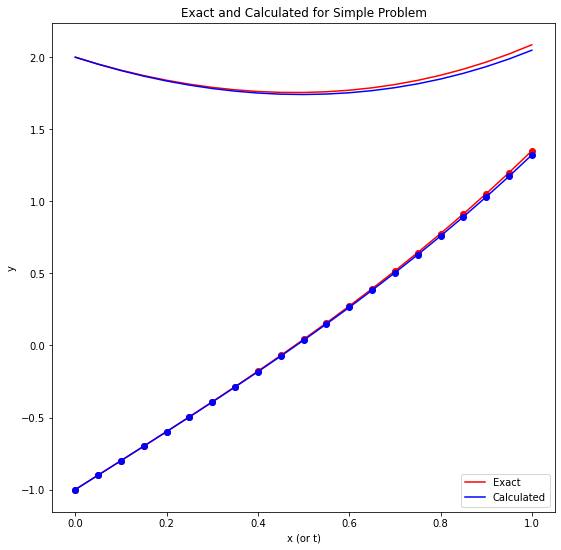

In [13]:
# Plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

# Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

# Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Exact and Calculated for Simple Problem')
ax.plot(positionList, truthList0, color='r', label="Exact")
ax.plot(positionList, calculatedList0, color='b', label="Calculated")
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.legend()

References: [1](#1) (reading files), [2](#2) (figure size), and [3](#3) (file access) 

The line with cirlces is $u'$, while the one without is $u$ itself. If the Euler method was used, as was set by default, we should see some clear divergence by the end of the procedure: the values start out nearly the same between calculated and exact but slowly diverge. Methods with orders that are much higher than Euler's will produce no discernable difference between the two graphs, everything will look blue. Which is not to say the result is perfect, merely that the difference is not discernable at this scale.

Therefore we usually don't try to compare data to truth this way, we instead look at the errors directly. 

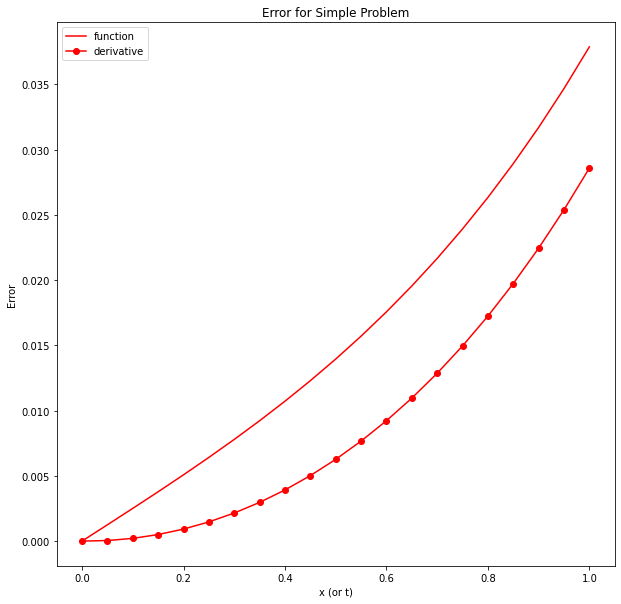

In [14]:
# Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title('Error for Simple Problem')
ax.plot(positionList, errorList0, color='r', label = "function")
ax.plot(positionList, errorList1, color='r', marker = 'o', label = "derivative")
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying. 
fig.set_size_inches(10,10)
ax.legend()

Admittedly, the above graph isn't particuarly illumiating in most cases, it genreally just shows that errors rise with time. The program reports error in an exact sense: it can be positive or negative and indicates precisely how far off from the truth the result was. Often, however, we care less about that and care more about the relative error, since that can be plotted on a logarithmic scale to tell us to how many significant figures our program matches the truth. 

In this case, we define relative error as shown below.

$$ \left| \frac{Truth - Calculated}{Truth} \right| $$

The errorr reported by the program is just $Truth - Calculated$. But no worries, this is very simple to resolve, for numpy can take the arrays we made and do operations on them. Like so...

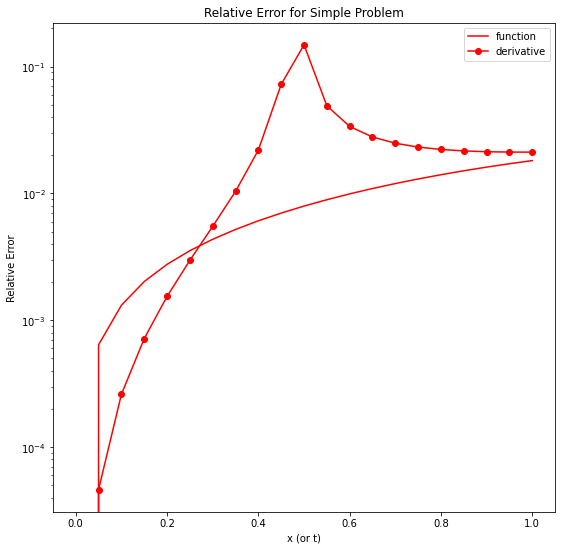

In [15]:
import numpy as np # numpy, for doing math with our data. 

# Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
truthList0 = []
truthList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title ('Relative Error for Simple Problem')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r', label="function")
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o',label = "derivative")
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

This tells us a lot more than the simple error plot! First of all, assuming the parameters have not been adjusted by the user, we can see clearly that the error starts at around 1e-3 and grows to 1e-2. Naturally this is not very good, less than 2 sig figs of agreement at the end, but this is Euler's method, we know it's not very good, we specifically chose it so we could visually see features on the full scale. 

One thing we do note is that the errors for the function $u$ are well behaved and don't do anything unusual, slowly growing as is to be expected. However, the errors for $u'$ spike in the middle! Why is this? Well, if we look at how $u'$ itself behaves in the first graph, that is where it crosses the axis—that is, $u'$=0 at some point. As the values get closer to zero, they get smaller and smaller, and thus the relative error between said values increases markedly. We could not see this feature in the direct error plot, but here it's on full display! Being aware of points where functions go to zero is an important part of analyzing them properly, and spikes like this in the error can be used to find them. 

These are generally the three graphs we make from one run of the program. However, there is more informaiton we can glean from running it multiple times. 

<a id='S2e'></a>

## Step 2e: Multiple-Run Examination \[Back to [top](#toc)\]
$$\label{S2e}$$

#### Sometimes doing it once just won't cut it.

Validation of the program can be done if it's run multiple times. In order to demonstrate this validation, we will run the program two times; both times using the RK4 method, but once at 0.01 step size, and another time at 0.02. Doing this is a simple as adjusting `nrpy_odiegm_main_c_modifiable` and calling NRPy+'s compiler again. 

Note: if running these cells independently, be sure to run the rest of this step first so it doesn't try to solve the system outlined in the latter sections of this notebook. 

In [16]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.01; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 2; // How many equations are in our system?
    int number_of_constants = 0; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = true; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = true;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "RKData01.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    // AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF.

"""

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    # prefunctions are functions declared outside main.
    # the specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    # just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    # what does main return?
    
    name = "main"
    # will almost always just be "main", but could be otherwise. 
    
    params = ""
    # various paremeters. Should be "" most often. 
    
    # Below is where the actual main function itself goes, constructed from the variables
    # defined in the customization section.
    # Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    # Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    # Now all those things we defined above are put into a function from outC, 
    # Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

os.chdir("../")
# return to parent directory

cmd.new_C_compile(Ccodesrootdir, "ODESolverSimple2", compiler_opt_option="fast")
# This just compiles the code into the specified file. 

os.chdir(Ccodesrootdir)
# Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverSimple2", "", "terminalOutput.txt")
# Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverSimple2 `...
(BENCH): Finished executing in 0.21 seconds.


In [17]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.02; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 2; // How many equations are in our system?
    int number_of_constants = 0; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 50; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = true; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = true;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "RKData02.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    // AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF.

"""

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # What "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    # Prefunctions are functions declared outside main.
    # The specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    # Just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    # What does main return?
    
    name = "main"
    # Will almost always just be "main", but could be otherwise. 
    
    params = ""
    # Various paremeters. Should be "" most often. 
    
    # Below is where the actual main function itself goes, constructed from the variables
    # defined above.
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    # Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    # Now all those things we defined above are put into a function from outC, 
    # Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

os.chdir("../")
# Return to parent directory

cmd.new_C_compile(Ccodesrootdir, "ODESolverSimple3", compiler_opt_option="fast")
# This just compiles the code into the specified file. 

os.chdir(Ccodesrootdir)
# Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverSimple3", "", "terminalOutput.txt")
# Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.41 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverSimple3 `...
(BENCH): Finished executing in 0.20 seconds.


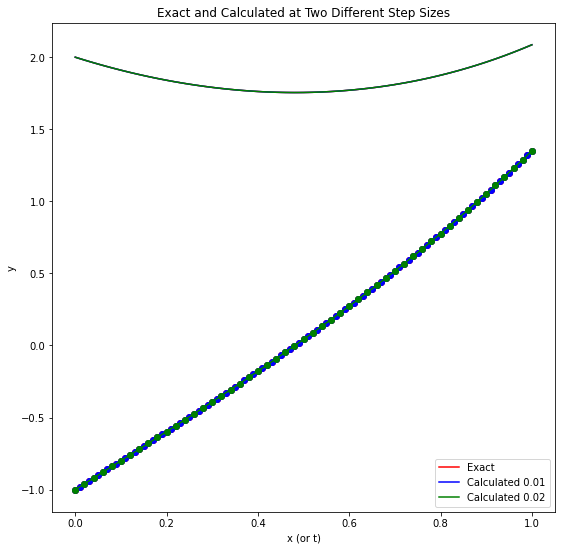

In [18]:
# Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []

# "a" appended to the front of lists to be used for the second data set.
# Truth list is irrelevant, the value is the same for both. 
apositionList = []
acalculatedList0 = []
acalculatedList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('RKData01.txt') as f: # shenangians required to access the previous file. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1
i = 0
with open('RKData02.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
            acalculatedList0.append(float(row[3]))
            acalculatedList1.append(float(row[5]))
        i = i+1


# Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Exact and Calculated at Two Different Step Sizes')
ax.plot(positionList, truthList0, color='r', label="Exact")
ax.plot(positionList, calculatedList0, color='b', label="Calculated 0.01")
ax.plot(apositionList, acalculatedList0, color='g', label="Calculated 0.02")
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')
ax.plot(apositionList, acalculatedList1, color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.legend()

Naturally, viewing it from the bird's eye view reveales absolutely nothing, as the exact, 0.01 step, and 0.02 step results are all essentially right on top of each other. We can tell that the resolution is different only because the dots use to mark $u'$ values are not in the same locations along the line. We have to examine the log plot to get anything useful out of this. 

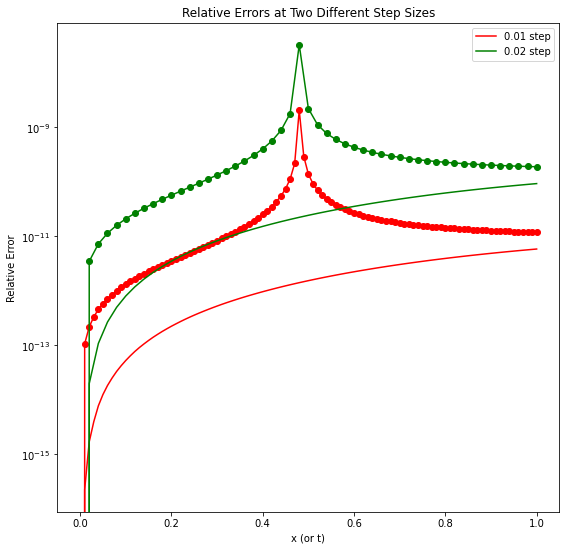

In [19]:
# Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

# "a" appended to the front of lists to be used for the second data set.
# Truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('RKData01.txt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open('RKData02.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

# Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title('Relative Errors at Two Different Step Sizes')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r', label = "0.01 step")
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)), color='g', label = "0.02 step")
ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

We note the very curious result that while the errors are different in magnitude, their shape is virtually identical. The fact that 0.02 has more error than 0.01 is expected: smaller step size leads to higher resolution. But it almost looks as though there is a relaiton between the two errors. That is because there is a relation, that relation is based on the order of the error itself. Adjusting the step size by a factor of two should introduce an error difference of around $2^m$, where $m$ is the order of the error. in this case, $m$ is 4, so we should see error adjustments by a factor of 16. Do we? 

The best way to test is just to plot it again, but scale one of the values by 16.

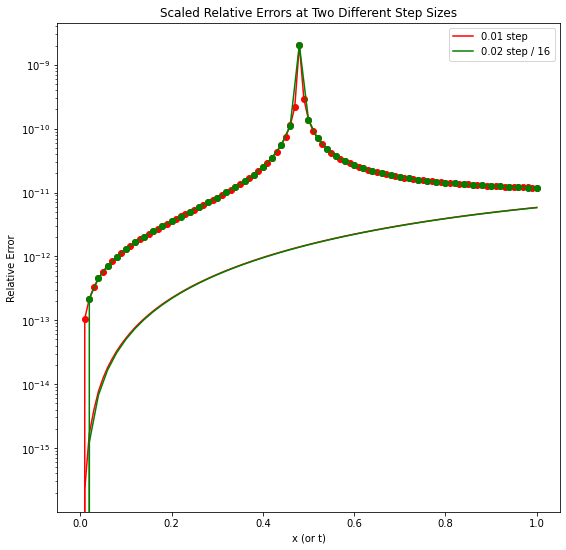

In [20]:
# Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

# "a" appended to the front of lists to be used for the second data set.
# Truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
# This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('RKData01.txt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open('RKData02.txt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

# Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title('Scaled Relative Errors at Two Different Step Sizes')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r', label = "0.01 step")
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)/16.0), color='g', label = "0.02 step / 16")
ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)/16.0), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

The scaling factor of 16 has made it so the two error plots are more or less right on top of each other. They agree remarkably, even near the spike as $u'$ approaches zero. 

This is effectively a validation check for the RK4 method itself—is it consistent with its supposed fourth-order accuracy? As we can see here, yes, absolutely. Everything matches. With that, we consider the Simple Example complete. We can now move on to a more complciated example, one where the truth is not known. 

This exact method was used to valudate accumulation error for the vast majority of available methods. This is admittedly only a visual validation of the data, but it is a pretty clear one. This validation fails at 8th order, for it becomes too difficult to get a smooth values that aren't interfered with by roundoff error. 

The user is enocuraged to edit the above code to test out different order methods, to see by what factor their relative errors differ. 

<a id='S3'></a>

## Step 3: Complicated Problem Example \[Back to [top](#toc)\]
$$\label{S3}$$

#### Don't hang up yet, I'm not done.

The program is more than capable of handling questions that are far more complicated than a simple second-order differential equation. For instance, in General Relativity there are a sequence of equations called the TOV equations, the primary instance of which is described on wikipedia [here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) for those who want more information. In genreal, the TOV equations represent a relativistic picture of a spherically symmetric star with respect to the radius. 

The specifics of why we wish to solve the TOV equations are unimportant, what is important is the form they take. There are many ways to state and evaluate them, but the one we will implement here is given by the following.

$$
\boxed{
\begin{matrix}
\frac{dP}{dr} &=& - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &=& \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\frac{m(r)}{dr} &=& 4\pi r^2 \rho(r) \\
\frac{d\bar{r}(r)}{dr} &=& \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}
\end{matrix}
}
$$

This is taken from the soon-to-be-depricated [NRPy+ TOV solver](http://localhost:8889/notebooks/Tutorial-ADM_Initial_Data-TOV.ipynb). (NOTE: link will either need to be changed or removed when this is added to nrpytutorial). $P$ is pressure, $\nu$ is related to the curved nature of spacetime, $m$ is the total enclosed mass of the star, and $\bar r$ is the isotropic radius (non-normalized). Though, really, as an example the physical meaning of the results are unimportant except for justifying some of the limitations we apply. 

In various implementations and models, the function $\rho$ (energy density) can vary. In our implementation here, we treat it as

$$ \rho(r) = \sqrt{P} + P, $$

which we will report as a separate constant, making use of Odie's functionality in this regard. For completeness, a fuller definition of $\rho(r)$ follows.

$$ \rho(r) = (P/K)^{1/\Gamma} (1 + \frac{P}{(P/K)^{1/\Gamma} (\Gamma - 1)})$$

However, in our implementation $K$=1 and $\Gamma = 2$ so it quickly reduces to our original declaration. (In actual implementations $K$ and $\Gamma$ themselves could vary as well, generally turning this equation into a piecewise one). 

Another thing we need is initial conditions. The pressure has to be specified ahead of time, but all other values start at zero. In our case, Pressure is 0.016714611225000002. 

With all this, we have 4 differential equations and 1 constant we wish to report. We also need to consider our boundary conditions. Generally, we start from the center of the star at $r$=0. This, naturally, will provide some issues as the solver will run into divide by zero errors if it tries to evaluate any point there. However, in our declaration we will demonstrate how to avoid this issue, as well as avoiding problems that will arise if, say, the pressure goes negative due to an estimation error and makes the energy density `NaN`, which breaks everything. It can all be handled in the program so long as it is implemented properly. 

Note that unlike the Simple Problem, we do not know what the answer should be ahead of time, so there will be no relative error reporting this time around—but we will still have other forms of analysis. 

Furthermore, unlike last time, we will demonstrate the use of adaptive time stepping with this example. 

<a id='S3a'></a>

## Step 3a: Complicated Problem Customization  \[Back to [top](#toc)\]
$$\label{S3a}$$

#### Curiously not much more complicated than the simple version of this section. 

Here is where users can adjust information in the notebook to adjust how the program runs. These changes only apply to the Complicated Example, the Simple Example has its own customization section. 

First, the `nrpy_odiegm_user_methods.c`.

In [21]:
nrpy_odiegm_user_methods_c = r"""

// #include <stdio.h>
// #include <stdlib.h>
// #include <math.h>
// #include <stdbool.h>

// This file holds all the functions and definitions for the user to edit. 
// Note that it does not depend on any of the other files--so long as the formatting is maintained
// the operation of the code should be agnostic to what the user puts in here. 

// This struct here holds any constant parameters we may wish to report.
// Often this struct can be entirely empty if the system of equations is self-contained.
// But if we had a system that relied on an Equation of State, 
// the parameters for that EOS would go here. 

struct constant_parameters { 
    int dimension; // number that says how many we have. 
    double rho;
    // add more as necessary. Label as desired. 
};

// Here are the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exception_handler (double x, double y[]); 
// Handles any exceptions the user may wish to define.
int do_we_terminate (double x, double y[], struct constant_parameters *params); 
// User-defined endpoint.
// Generally used if the code won't terminate itself from outside, or if there's a variable condition. 
void const_eval (double x, const double y[], struct constant_parameters *params);
// Assign constants to the constant_parameters struct based on values in y[]. 
int diffy_Q_eval (double x, double y[], double dydx[], void *params);
// The definition for the system of equations itself goes here. 
int known_Q_eval (double x, double y[]);
// If an exact solution is known, it goes here, otherwise leave empty. 
void get_initial_condition (double y[]);
// Initial conditions for the system of differential equations. 
void assign_constants (double c[], struct constant_parameters *params);
// Used to read values from constant_parameters into an array so they can be reported in sequence. 

// Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
// to rename the functions if desired, though since diffy_Q_eval and known_Q_eval are passed to 
// one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
// NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
// only change names if creating a new custom main function. 

void exception_handler (double x, double y[])
{
    // This funciton might be empty. It's only used if the user wants to hard code some limitations 
    // on some varaibles.
    // Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    // In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    // Physically, it cannot, but approximation methods can cross the P=0 line
    // We just need a hard wall to prevent that. 
}

int do_we_terminate (double x, double y[], struct constant_parameters *params)
{
    // This funciton might be empty. It's only used if the user wants to have 
    // a special termination condition.
    // Today we do. We terminate once the pressure hits zero, or goes below it. 
    // Notably we also consider ridiculously small pressures to be "zero" since we might be asymptotic. 
    if (y[0] < 1e-16) {
        return 1;
    } else {
        return 0;
    }
    // return 1; for termination.
}

void const_eval (double x, const double y[], struct constant_parameters *params)
{
    // Sometimes we want to evaluate constants in the equation that change, 
    // but do not have derivative forms.
    // Today, we do that for the total energy density. 
    params->rho = sqrt(y[0]) + y[0];
    // The total energy density only depends on pressure. 
}

int diffy_Q_eval (double x, double y[], double dydx[], void *params)
{
    // GSL-adapted evaluation function. 
    // It is possible to do this with one array, but GSL expects two. 

    // Always check for exceptions first, then perform evaluations. 
    exception_handler(x,y);
    const_eval(x,y,params);

    // Dereference the struct
    double rho = (*(struct constant_parameters*)params).rho;
    // double parameter = (*(struct constant_parameters*)params).parameter;
    // WHY oh WHY GSL do you demand we use a VOID POINTER to the struct...?
    // https://stackoverflow.com/questions/51052314/access-variables-in-struct-from-void-pointer
    // Make sure to dereference every parameter within the struct so it can be used below. 

    // This if statement is an example of a special condition, 
    // in this case at x=0 we have a divide by zero problem. 
    // Fortunately, we manually know what the derivatives should be.
    // Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        dydx[0] = 0; 
        dydx[1] = 0;
        dydx[2] = 0;
        dydx[3] = 1;
    }
    else {
        dydx[0] = -((rho+y[0])*( (2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0] ))/(x*2.0*(1.0 - (2.0*y[2])/(x)));
        dydx[1] =  ((2.0*y[2])/(x) + 8.0*3.1415926535897931160*x*x*y[0])/(x*(1.0 - (2.0*y[2])/(x)));
        dydx[2] = 4*3.1415926535897931160*x*x*rho;
        dydx[3] = (y[3])/(x*sqrt(1.0-(2.0*y[2])/x));
        // Visual Studio likes to complain that M_PI is not defined, even though it is. 
        // So we used 3.1415926535897931160. which is just M_PI printed out to extra digits.
        // There was no observed change in the final product. 
    }
    // This funciton is not guaranteed to work in all cases. For instance, we have manually 
    // made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    // Be sure to declare any exceptions before running, both here and in exception_handler, 
    // depending on the kind of exception desired.  

    return 0;
    // GSL_SUCCESS is 0. We do not support fancy error codes like GSL. 
}

// This is the function to evaluate the known solution. Must be set manually.
int known_Q_eval (double x, double y[]) // This function is another one passed using GSL's formulation. 
// Allows the nrpy_odiegm_user_methods.c file to be completely agnostic to whatever the user is doing. 
{
    // y[0] = ...
    // y[1] = ...
    // This function is only used if there are known solutions. 
    // Notably this is not the case for the TOV equations. 
    // If you do put anything here, make SURE it has the same order as the differential equations. 
    // In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 

    return 1;
    // report "success," what would have been GSL_SUCCESS in the GSL formulation. 
}

void get_initial_condition (double y[])
{
    // be sure to have these MATCH the equations in diffy_Q_eval
    y[0] = 0.016714611225000002; // Pressure, can be calcualated from central baryon density. 
    y[1] = 0.0; // nu
    y[2] = 0.0; // mass
    y[3] = 0.0; // r-bar
}

void assign_constants (double c[], struct constant_parameters *params)
{
    // Reading parameters from the constant_parameters struct is rather difficult, since it exists
    // in the higher order "objects" as a void pointer. So the user should declare what constants
    // are what for ease of use, usually for printing in an algorithmic way.
    c[0] = params->rho; // Total energy density. 
    // Add more as required. 
}

"""

Note that we are now using *all* the functions in `nrpy_odiegm_user_methods.c` save for `known_q_eval`. 

Now the leading part of `nrpy_odiegm_main.c`...

In [22]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.00001; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oCData.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

<a id='S3b'></a>

## Step 3b: Complicated Problem Code Compilation \[Back to [top](#toc)\]
$$\label{S3b}$$

#### The snakes complain that there's nothing different to do here. 

As with the simple example, we compile the C-code and run it via NRPy+'s methods. Very little is changed.

In [23]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # What "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    # Prefunctions are functions declared outside main.
    # The specifics of what go here were declared above. 
    
    desc = "Complicated Example: TOV Solver"
    # Just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    # What does main return?
    
    name = "main"
    # Will almost always just be "main", but could be otherwise. 
    
    params = ""
    # Various paremeters. Should be "" most often. 
    
    # Below is where the actual main function itself goes, constructed from the variables
    # defined above.
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    # Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    # Now all those things we defined above are put into a function from outC, 
    # Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above.

os.chdir("../")
# Return to parent directory

cmd.new_C_compile(Ccodesrootdir, "ODESolverComplicated1", compiler_opt_option="fast")
# This just compiles the code into the specified file. 

os.chdir(Ccodesrootdir)
# Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverComplicated1", "", "terminalOutput.txt")
# Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverComplicated1 `...
(BENCH): Finished executing in 0.20 seconds.


<a id='S3c'></a>

## Step 3c: Complicated Problem Results \[Back to [top](#toc)\]
$$\label{S3c}$$

#### If it isn't the consequences of my own actions. ...Again. 

First, let's see what the terminal printed. 

In [24]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V10...
Method Order: 4.
Printing to file 'oCData.txt'.
INITIAL: Position:,	0.000000,	Equation 0:,	1.67146112250000e-02,	Equation 1:,	0.00000000000000e+00,	Equation 2:,	0.00000000000000e+00,	Equation 3:,	0.00000000000000e+00,	Constant 0:,	1.45999611225000e-01,	
FINAL: Position:,	9.56604504673252e-01,	Equation 0:,	0.00000000000000e+00,	Equation 1:,	4.59952331801525e-01,	Equation 2:,	1.40503033677089e-01,	Equation 3:,	1.15746784583246e+00,	Constant 0:,	0.00000000000000e+00,	
ODE Solver "Odie" V10 Shutting Down...



Do note that we now report the constant as well! 

The actual data produced by the program is below. Note: if the user altered the code and chose a setup that resulted in a very long set of data, it will be cut off by the jupyter notebook. The file itself will still exist, though. 

In [25]:
with open("oCData.txt") as f:
    print(f.read())

Position:,	0.00000000000000e+00,	Equation 0:,	1.67146112250000e-02,	Equation 1:,	0.00000000000000e+00,	Equation 2:,	0.00000000000000e+00,	Equation 3:,	0.00000000000000e+00,	Constant 0:,	1.45999611225000e-01,	
Position:,	1.00000000000000e-05,	Equation 0:,	1.67146112179846e-02,	Equation 1:,	8.62303740841765e-11,	Equation 2:,	6.11561741308734e-16,	Equation 3:,	1.00000000003037e-05,	Constant 0:,	1.45999611190853e-01,	
Position:,	1.40613765222082e-05,	Equation 0:,	1.67146112114523e-02,	Equation 1:,	1.66521252757759e-10,	Equation 2:,	1.70029321224058e-15,	Equation 3:,	1.40613765230553e-05,	Constant 0:,	1.45999611159058e-01,	
Position:,	1.81227530444164e-05,	Equation 0:,	1.67146112027150e-02,	Equation 1:,	2.73915401060339e-10,	Equation 2:,	3.64009590207511e-15,	Equation 3:,	1.81227530462325e-05,	Constant 0:,	1.45999611116530e-01,	
Position:,	2.28342718558516e-05,	Equation 0:,	1.67146111898162e-02,	Equation 1:,	4.32460912130805e-10,	Equation 2:,	7.28118071572920e-15,	Equation 3:,	2.28342718594

Note that there are no errors reported, just the positions, values of our functions, and the value of our constant. This should be the full solution to the system of differential equations. 

<a id='S3d'></a>

## Step 3d: Complicated Problem Analysis \[Back to [top](#toc)\]
$$\label{S3d}$$

#### Time to go mining again. 

Let's just print out our equations and constant, see how they behave. 

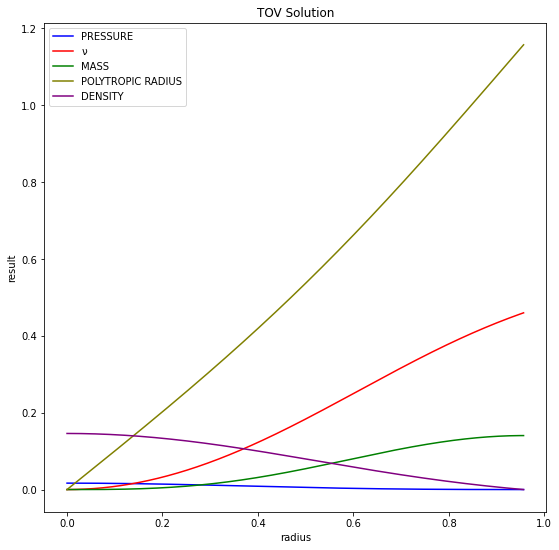

In [26]:
# plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

# Csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution')
ax.plot(positionList, calculatedList0, color='b', label="PRESSURE") 
ax.plot(positionList, calculatedList1, color='r', label="ν") 
ax.plot(positionList, calculatedList2, color='g', label="MASS") 
ax.plot(positionList, calculatedList3, color='olive', label="POLYTROPIC RADIUS") 
ax.plot(positionList, calculatedList4, color='purple', label="DENSITY") 

# plt.ylim(0.0,0.15)
# plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.legend()

Well, everything looks nice and smooth, but a lot of the information here is condensed at the bottom of the graph. Let's zoom in to examine the detail. 

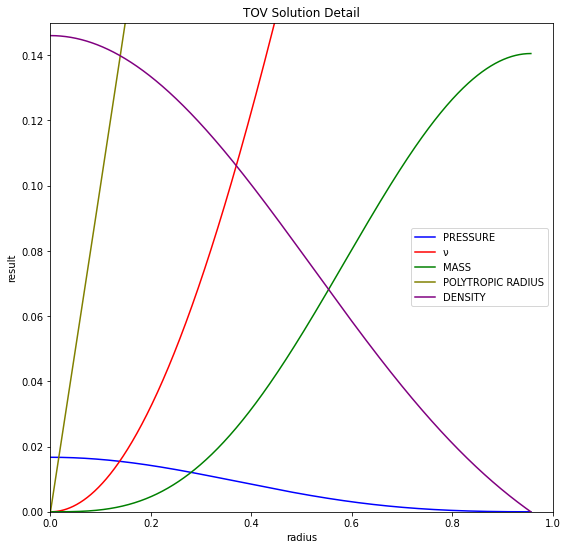

In [27]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution Detail')
ax.plot(positionList, calculatedList0, color='b', label="PRESSURE") 
ax.plot(positionList, calculatedList1, color='r', label="ν") 
ax.plot(positionList, calculatedList2, color='g', label="MASS") 
ax.plot(positionList, calculatedList3, color='olive', label="POLYTROPIC RADIUS") 
ax.plot(positionList, calculatedList4, color='purple', label="DENSITY") 

plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.legend()

From this, we can confirm that our termination condition is working: we clearly stop as the pressure goes to zero. The density and pressure act as expected, starting high in the center of the star and going to zero, while the mass levels off to a certain value (since the mass would all be contained within the star, this makes sense). All we can say about $\bar r$ is that it's increasing similarly but not exactly to $r$ itself, which is expected. Now, we happen to know that $\bar r$ needs to be normalized, but the solver doesn't do that—we'll show how to do post-processing later. 

For now, we discuss validation. We don't have a closed form solution for the TOV equations, but we do have a solution printed out by a previous NPRy+ solver that solved TOV equations specifically. Let's compare our results shall we? 

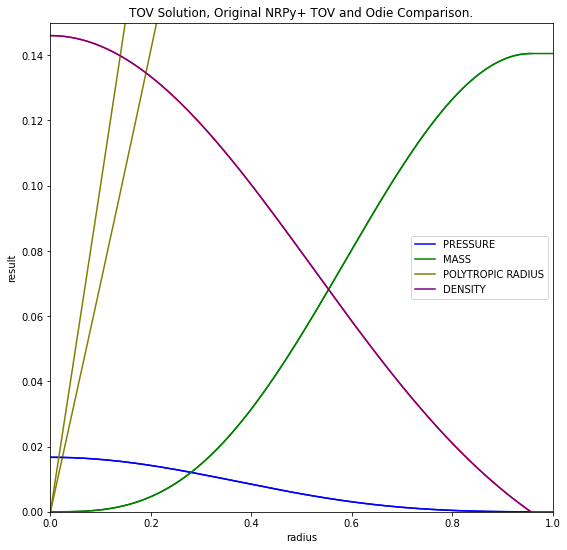

In [28]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution, Original NRPy+ TOV and Odie Comparison.')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 

ax.plot(apositionList, acalculatedList0, color='b', label = "PRESSURE") 
ax.plot(apositionList, acalculatedList2, color='g', label = "MASS") 
ax.plot(apositionList, acalculatedList3, color='olive', label = "POLYTROPIC RADIUS") 
ax.plot(apositionList, acalculatedList4, color='purple', label = "DENSITY") 

plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.legend()

We can see rather clearly that pressure, mass, and total energy density visually match the values reported by the trusted solver, with the notable exception that the solver continued evolving past $P$=0 and so we have some trailling flat lines at the end. However, $\bar r$ does not match. This is because, as previously mentioned, we have not normalized the data. Normalization of $\bar r$ requires knowing what the estimate for values at the edge of the star are, which can't be done until the entire differential equation is already solved, so this is why we do it now. The below code demonstrates how to use numpy to do this post-processing. 

$\nu$ is not reported in this graph since the NRPy+ solver did not report it. 

The normalization factor for $\bar r$ is the following.

$$\frac{1}{2} \frac{\sqrt{R(R-2M) + R-M}}{\bar R}$$

Here, $R$ is the radius of the star, $M$ is the mass, and $\bar R$ is the non-normalized isotropic radius of the star. These will be the *last* values in the lists of our data since we made sure to terminate at $P$=0.  

Also, it is often convenient to set the radius of the star to 1, so we also do that in the processing below. 

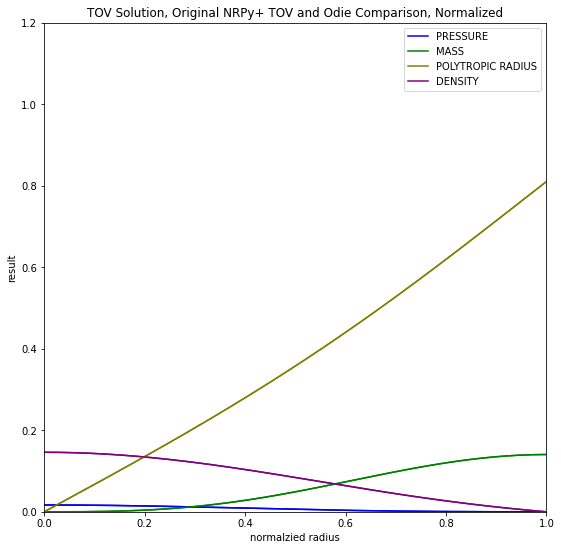

In [29]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('normalzied radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution, Original NRPy+ TOV and Odie Comparison, Normalized')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

# POST PROCESSING!
# Now that we have all our data in lists, we can harvest the last values using Python's "-1" index trick.
R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

# Calculate the normalization constant for r_bar
C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw
        
    
# We multiply all positions by 1/R_Schw in order to normalize the radius to 1.
ax.plot(np.array(positionList)*(1.0/R_Schw), calculatedList0, color='b') 
ax.plot(np.array(positionList)*(1.0/R_Schw), calculatedList1, color='purple') 
ax.plot(np.array(positionList)*(1.0/R_Schw), calculatedList2, color='g') 
ax.plot(np.array(positionList)*(1.0/R_Schw), calculatedList3, color='olive') 


ax.plot(np.array(apositionList)*(1.0/R_Schw), acalculatedList0, color='b', label = "PRESSURE") 
ax.plot(np.array(apositionList)*(1.0/R_Schw), acalculatedList2, color='g', label = "MASS") 
# Make sure to actually normalize r-bar when plotting it. numpy can perform operations on the list if
# we convert it to a numpy array. 
ax.plot(np.array(apositionList)*(1.0/R_Schw), np.array(acalculatedList3)*C, color='olive', label = "POLYTROPIC RADIUS") 
ax.plot(np.array(apositionList)*(1.0/R_Schw), acalculatedList4, color='purple', label = "DENSITY") 


plt.ylim(0.0,1.2)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.legend()

We zoomed out so we could focus on $\bar r$ here. As we can see, now that it's normalized, both the trusted NRPy+ result and our program plot what is visually the same thing. This serves as a demonstration on how to do post-processing on Odie's data. Odie can only solve ODEs, it can't analyze the results or alter data that depends on the final result, such as the normalized radius or $\bar r$ here. That is left to the user to do with whatever program is going to be plotting or analyzing the data. 

Anyway, while the graph above looks great, just because things are similar visually doesn't mean the errors are as small as we would like. Sadly, even though we have a trusted solution, it itself is just an approximation method and is not perfect, so we can't determine "digits of agreement" with the truth since the truth isn't known to absolute precision. Furthermore, both solvers plot distinct points, and those points genreally don't line up so we can't easily compare them. 

There is a solution, however. It is a little messy, but we can use scypy's advanced interpolation functions to draw lines that connect the data points together so they can be compared. This is, admittedly, a second level of approximation being added to the data, but with luck it will show us that the two answers agree extremely closely. To do that, we will cubically interpolate the NRPy+ data so it can be evaluated at the same points our solver has results at, then we can compare those. 

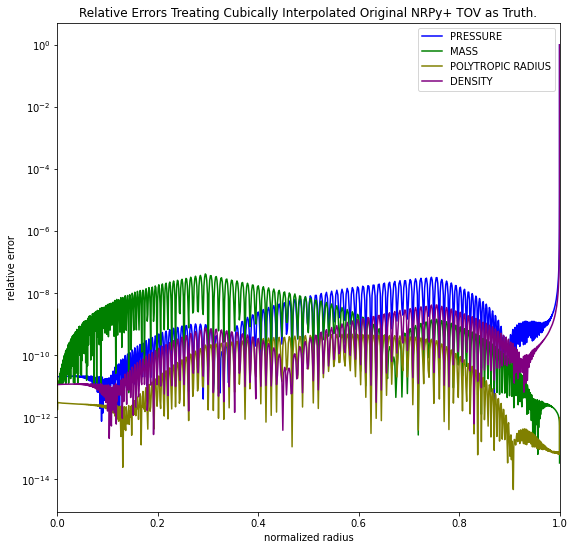

In [30]:
# Plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors Treating Cubically Interpolated Original NRPy+ TOV as Truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

# Here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) # Collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") # Interpolate cubically between them. 
xnew = apositionList # Make the step size equal to our solver's.
xnew.pop(0)
ynew = f0(xnew) # Use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 # Manually put our solver's values in, we wish to avoid double interpolating
ynew2.pop(0) # The first value, printed at r=0, is not reported in the Original NRPy+ solver, get rid of it. 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'blue', label="PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew) # Use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
ynew2.pop(0) # The first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'green', label="MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew) # Use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
ynew2.pop(0) # The first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label="POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew) # Use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
ynew2.pop(0) # The first value, printd at zero, is not reported in the NRPy+ solver, get rid of it
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'purple', label="DENSITY")

# plt.ylim(0,0.001)
plt.xlim(0.0,1)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

Well that is certainly an absolute mess. Let's run it again but zoom in so we can actually talk about what's going on. 

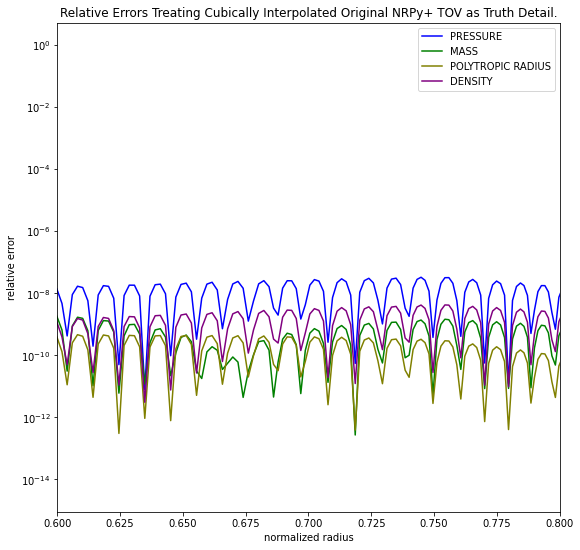

In [31]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors Treating Cubically Interpolated Original NRPy+ TOV as Truth Detail.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) 
f0 = interpolate.interp1d(x0, y0, "cubic") 
xnew = apositionList 
xnew.pop(0)
ynew = f0(xnew)  
ynew2 = acalculatedList0 
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'blue', label="PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew) 
ynew2 = acalculatedList2
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'green', label="MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew) 
ynew2 = acalculatedList3
ynew2.pop(0)
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label="POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew) 
ynew2 = acalculatedList4
ynew2.pop(0)
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'purple', label="DENSITY")

# plt.ylim(0,0.001)
plt.xlim(0.6,0.8)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()


We see here a shape that regularly appears in error analysis: the COMB. 

The comb occurs when we have two sets of data that are reported at different resolutions but nonetheless represent the same quantity. As we can see, all four quantities we can compare demonstrate the comb effect. 

What's happening is that the original NRPy+ TOV solver and Odie don't sample the same points, but they sample points near each other, and the points that are nearest to each other have the lowest interpolation error. Every time the points line up, we get a downward spike in the comb, where we can get up to twelve digits of agreement, while the places that are furthest away from each other get around eight digits of agreement. These errors are largely due to the errors of the cupic interpolator itself, which is not able to perfectly smooth out all the data to make comparisons. However, even the worst parts of the interpolator only get errors of 7 digits, barring the spike that occurs at the edge of the star due to some values drifting near to zero. 

Keep in mind this does not necessarily mean Odie is "less accurate" than the original NRPy+ TOV solver. All we can say is that we are extremely close to what the NRPy+ TOV solver thinks the answer is near the points where the NRPy+ TOV solver was actually evaluating, which means the disagreement between them is minimal. It is impossible to reduce the disagreement to absolutely zero, since we use different stepping methods and have a slightly different (more general) implementaiton. 

One thing we can note is that this comb demonstrates how our method is using adaptive timestep: the lines are not smooth and are instead angled, with a conrner at every sampled point. This is primarly because we chose to interpolate the original NRPy+ TOV solver's data to match up with our own, so we see corners where Odie was evaluating and spikes where NRPy+ TOV was evaluating. Note that width between the spikes isn't consistent across the whole domain, since the original solver was changing its time step. We are also changing ours, which we can see from the distance between corners on the left of the comb being greater than on the right side of the comb. 

What happened is that Odie detected that the estimated error was growing above the desired bound during runtime, and thus shrunk the step size to increase accuracy. We can actually plot the step size based on the position, to get a better idea of what the program is doing. 

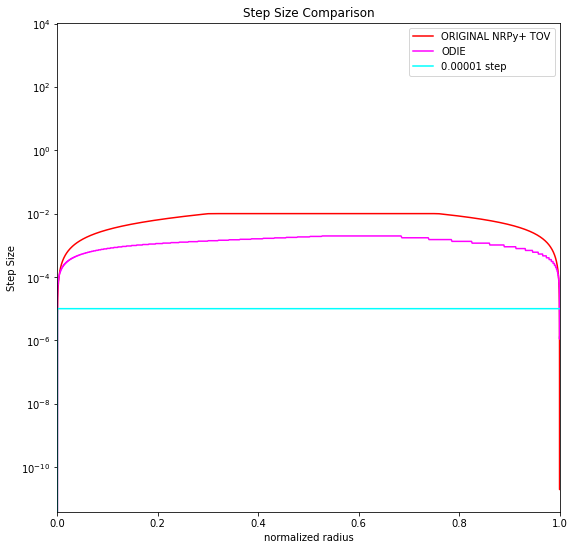

In [32]:
positionListMedium = []
positionListODE = []
positionListODE2 = np.arange(0,1,0.00001)
       
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionListMedium.append(float(row[0]))

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionListODE.append(float(row[1]))   
        
dpositionListMedium = []
dpositionListODE = []
dpositionListODE2 = []
    
i = 0
while i < len(positionListMedium):
    if (i == 0):
        dpositionListMedium.append(0.0)
    else :
        dpositionListMedium.append(positionListMedium[i] - positionListMedium[i-1])
    i = i + 1

i = 0
while i < len(positionListODE):
    if (i == 0):
        dpositionListODE.append(0.0)
    else :
        dpositionListODE.append(positionListODE[i] - positionListODE[i-1])
    i = i + 1

i = 0
while i < len(positionListODE2):
    if (i == 0):
        dpositionListODE2.append(0.0)
    else :
        dpositionListODE2.append(positionListODE2[i] - positionListODE2[i-1])
    i = i + 1
    
fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('Step Size')
ax.set_title('Step Size Comparison')

ax.plot(np.array(positionListMedium)/R_Schw, dpositionListMedium, color='r', label="ORIGINAL NRPy+ TOV") 
ax.plot(np.array(positionListODE)/R_Schw, dpositionListODE, color='magenta', label="ODIE") 
ax.plot(np.array(positionListODE2)/R_Schw, dpositionListODE2, color='cyan', label="0.00001 step") 

# plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

The top line is for the original solver, Odie is below it, and below that is a straight line representing a non-adaptive stepsize. Odie takes smaller steps than the original solver for the RK4 method and the error limits we imposed on it, which implies that the results Odie produces should be more acurate than the original solver. However, the original solver was designed explicitly for the TOV equations and handles the core and edge of the star better, while Odie is entirely general it its application. We can also see that the original solver adjusted step size smothly, while Odie makes little staircase shapes as Odie has a "happy zone" where it will not adjust the step size, while the original solver would adjust the step virtually every time. 

Naturally, the non-adaptive timestep solution should be much more accurate than both of the above adaptive ones, since it takes smaller steps. And it is, it's just that taking larger steps when there are less errors about is far more computationally efficient. For a somewhat small number of evaluations like this, the difference in computaiton time is barely noticable, but for larger projects the time saved adds up quickly. 

In the interests of completeness we will run a non-adaptive version of the TOV equations, just to see the result. 

In [33]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.00001; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = true; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oCData2.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_RK4;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_RK4;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 


"""

In [34]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    
    desc = "Complicated Example: TOV Solver"
    
    c_type = "int" 
    
    name = "main"
    
    params = ""
    
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard

    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    
add_to_Cfunction_dict_ODESolver()

os.chdir("../")

cmd.new_C_compile(Ccodesrootdir, "ODESolverComplicated2", compiler_opt_option="fast")

os.chdir(Ccodesrootdir)

cmd.Execute("ODESolverComplicated2", "", "terminalOutput.txt")

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.41 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverComplicated2 `...
(BENCH): Finished executing in 0.41 seconds.


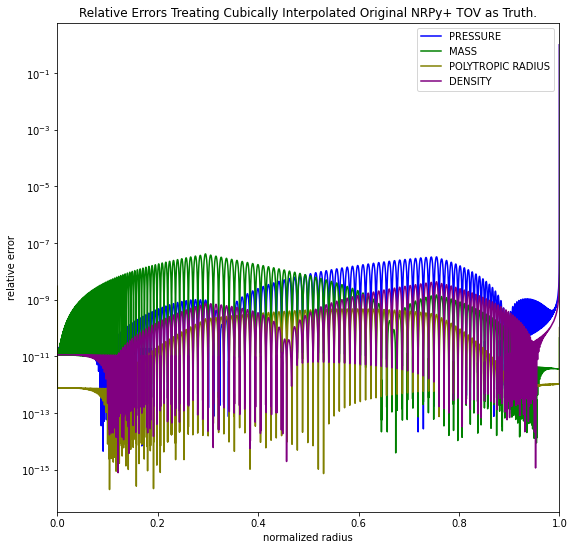

In [35]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData2.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors Treating Cubically Interpolated Original NRPy+ TOV as Truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) 
f0 = interpolate.interp1d(x0, y0, "cubic")
xnew = apositionList 
xnew.pop(0)
ynew = f0(xnew) 
ynew2 = acalculatedList0 
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'blue', label="PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew) 
ynew2 = acalculatedList2
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'green', label="MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew) 
ynew2 = acalculatedList3
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label="POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew) 
ynew2 = acalculatedList4
ynew2.pop(0)
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'purple', label="DENSITY")

# plt.ylim(0,0.001)
plt.xlim(0.0,1)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

Note that while the general shape of the graph here is the same, the spikes go down much further, all the way to 15 digits of agreement in some cases! This is because the steps for the nonadaptive version of Odie are much finer and can get much closer to the actual values that the original code was evaluating. The humps, though, are still the same, and are presumably based in interpolation error. 

The other change is the edge of the star, which is unsurprising. The edge of the star is an extremely volatile region and slight changes in timestep result in wildly different results. Smaller is still better, but the different adaptive methods can do all sorts of things out here. 

One might consider doing a Hybrid method, but not the sort of one that `nrpy_odiegm_main.c` can do automatically, where instead of shifting from an RK method to an AB method, we shift from an adaptive RK to a non-adaptive RK. But that's beyond the scope of this tutorial. That said, we will still demonstrate the use of AB and Hybrid methods below. 

<a id='S3e'></a>

# Step 3e: Complicated Problem Extension: Adams Bashforth and Hybrid Methods \[Back to [top](#toc)\]
$$\label{S3e}$$

#### Our code is mutating! 

Let's have ODIE solve the TOV equations with a pure Adams-Bashforth (AB) method.

In [36]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.00001; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oCData3.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_AB;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_AB;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 


"""

In [37]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    
    desc = "Complicated Example: TOV Solver"
    
    c_type = "int" 
    
    name = "main"
    
    params = ""

    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard

    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    
add_to_Cfunction_dict_ODESolver()

os.chdir("../")

cmd.new_C_compile(Ccodesrootdir, "ODESolverComplicated3", compiler_opt_option="fast")

os.chdir(Ccodesrootdir)

cmd.Execute("ODESolverComplicated3", "", "terminalOutput.txt") 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverComplicated3 `...
(BENCH): Finished executing in 0.40 seconds.


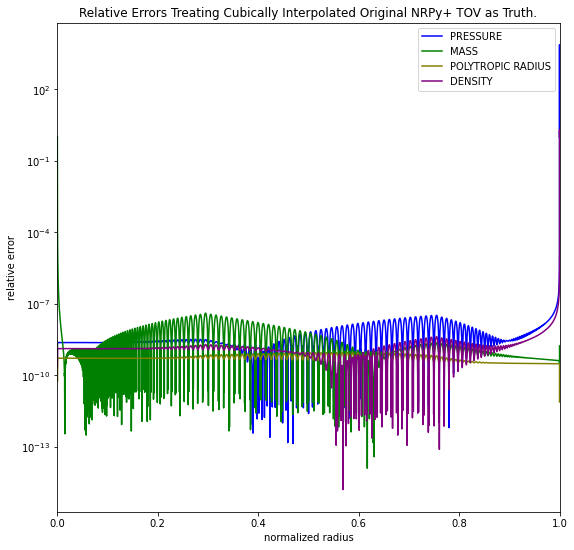

In [38]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData3.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors Treating Cubically Interpolated Original NRPy+ TOV as Truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) 
f0 = interpolate.interp1d(x0, y0, "cubic") 
xnew = apositionList
xnew.pop(0)
ynew = f0(xnew) 
ynew2 = acalculatedList0 
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'blue', label="PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew) 
ynew2 = acalculatedList2
ynew2.pop(0)
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'green', label="MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew) 
ynew2 = acalculatedList3
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label="POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew) 
ynew2 = acalculatedList4
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'purple', label="DENSITY")

# plt.ylim(0,0.001)
plt.xlim(0.0,1)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

This is a 4th order AB method, which theoretically is comparable to the RK4 method used previously. Note that the errors now cluster at values at less than 10 digits of agreement, which is less accurate than what RK4 showed. Even though AB methods aren't adaptive, this is still worse than the adaptive methods!

This is because AB methods take into account previously evaluated points, and in order to use a pure AB-method, lower order AB methods must be used to fill in the first few data points, and that error carries throughout the calculation. The solution is to use a hybrid method, where we "seed" the first few values with another method, then hand it off to AB. Since we only need to evaluate the first handful of points, we can go ahead and use a very intensive method to get those first points as accurate as possible. The best one we have is DP8, an RK method of 8th order. The first three points will be evaluated this way, and then we hand it off to AB of order 4 to continue the rest of the way. 

In [39]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    // SECTION I: Preliminaries

    // Before the program actually starts, variables need to be created
    // and set, as well as the functions chosen. 
    // The system of differential equations can be found declared in diffy_Q_eval
    // in nrpy_odiegm_user_methods.c

    double step = 0.00001; /// the "step" value. Initial step if using an adaptive method.
    double current_position = 0.0; // where the boundary/initial condition is. 
    // Same for every equation in the system.
    int number_of_equations = 4; // How many equations are in our system?
    int number_of_constants = 1; // How many constants do we wish to separately evaluate and report? 
    // If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    // and cause an overflow in the functions in nrpy_odiegm_user_methods.c
    const int size = 100000; // How many steps are we going to take? 
    // This is the default termination condition. 
    int adams_bashforth_order = 4; // If using the AB method, specify which order you want.
    // If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool no_adaptive_step = false; // Sometimes we just want to step forward uniformly 
    // without using GSL's awkward setup. False by default. 

    bool report_error_actual = false;
    bool report_error_estimates = false;
    // AB methods do not report error estimates. 
    // BE WARNED: setting reporError (either kind) to true makes
    // it print out all error data on another line,
    // the file will have to be read differently. 

    // ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absolute_error_limit = 1e-14; // How big do we let the absolute error be?
    double relative_error_limit = 1e-14; // How big do we let the relative error be?
    // Default: 1e-14 for both.
    // Note: there are a lot more error control numbers that can be set inside the 
    // control "object" (struct) d->c.

    char file_name[] = "oCData4.txt"; // Where do you want the data to print?

    // Now we set up the method. 
    const nrpy_odiegm_step_type * step_type;
    step_type = nrpy_odiegm_step_AB;
    // Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * step_type_2;
    step_type_2 = nrpy_odiegm_step_DP8;
    // This is a second step type "object" (struct) for hybridizing. 
    // Only used if the original type is AB.
    // Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 


"""

In [40]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]

    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    
    desc = "Complicated Example: TOV Solver"
    
    c_type = "int" 
    
    name = "main"
    
    params = ""

    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard

    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)

add_to_Cfunction_dict_ODESolver() 

os.chdir("../")

cmd.new_C_compile(Ccodesrootdir, "ODESolverComplicated4", compiler_opt_option="fast")

os.chdir(Ccodesrootdir)

cmd.Execute("ODESolverComplicated4", "", "terminalOutput.txt")

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.41 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverComplicated4 `...
(BENCH): Finished executing in 0.41 seconds.


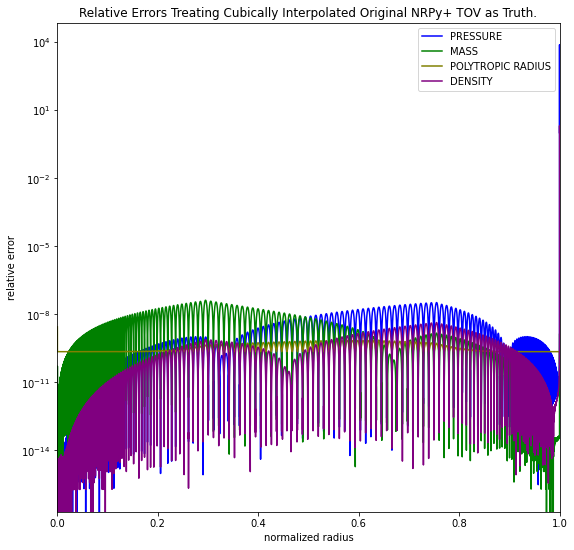

In [41]:
positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: # Data from Original NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData4.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('normalized radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors Treating Cubically Interpolated Original NRPy+ TOV as Truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) 
f0 = interpolate.interp1d(x0, y0, "cubic") 
xnew = apositionList 
xnew.pop(0)
ynew = f0(xnew)  
ynew2 = acalculatedList0 
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'blue', label="PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew) 
ynew2 = acalculatedList2
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'green', label="MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)
ynew2 = acalculatedList3
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label="POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)
ynew2 = acalculatedList4
ynew2.pop(0) 
plt.plot(np.array(xnew)*(1.0/R_Schw), abs((ynew-ynew2)/ynew), 'purple', label="DENSITY")

# plt.ylim(0,0.001)
plt.xlim(0.0,1)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") # Found in matplotlib's documentation.
ax.legend()

Note that at the core of the star this works *excellently*, the agreement is better than even our original results with adaptive RK4, and it continues far beyond the point at which DP8 is actually being used. This is the highest agreement we've seen so far. 

Choosing which methods to use and when is a bit of an art. Different problems behave differently for different types of methods, be they adaptive, nonadaptive, or rely on previously evaluated points. Learning when to choose certain things and when not to is best learned by experimenting. Users should feel free to change the methods used in the above code, adjust the order of the AB method, see what can be found. Of note, very high-order AB methods are unstable and are unlikely to give good results no matter what. Adaptive methods can often break as well if the error requirements are too stringent—or too weak! There are so many different variables to discover and tweak. The user can feel free to edit code in this section to see what happens, but there is also a playground specifically designed for user use in the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook.

<a id='S4'></a>

# Step 4: Conclusion \[Back to [top](#toc)\]
$$\label{S4}$$

#### So, what have we learned today?

In the previous sections we showcased two different examples of how Odie can be used to solve systems of Ordinary Differential Equations, making use of most of Odie's capabilities and showcasing how to turn the results into something useful. If users feel comfortable and have read at least the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook, the next step should be to do the Exercises in the next section of this notebook. 

Beyond that, a user with a specific application in mind could use the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook's template to run whatever system of ODEs that needs to be solved. However, in the case of a more complex and invovled situation, it is recommended to run the code in C directly. If more advanced applications are needed, it is time to turn to the [Full Documentation](NRPy+_OdieGM_Full_Documentation.ipynb) notebook to find out exactly how many parts of Odie can be customized when a custom main function is created. 

For an extremely involved application of Odie, some of the program's structure will likely need to be fundamentally altered. Fortunately we also have an example of this, though not in jupyter notebook format. Odie's personal repository at https://github.com/GMBlackjack/ODESolver has a folder called TOVOdieGM. This contains a version of Odie specifically designed to solve the TOV Equations in complete generality in the Einstein Toolkit environment. Many fundamental things were changed to make this work seamlessly with the rest of the programs in the Toolkit, and it is not considered an example to follow as a template, but merely a proof of concept that the code can be adapted to even highly specific and restrictive situations and structures.

Users are completely free to edit the code however desired. Even the header file and the functions usually kept from the user—there is nothing preventing adjustments. That said, the intent of Odie is to make it simple for users to solve ODEs of any sort; just because the option exists to edit everything doesn't mean it should be taken. Just put the differential equations into `nrpy_odiegm_user_methods.c` and run the main function with whatever settings are desired. This notebook gives a good idea of what parts of the code are expected to be altered in both `nrpy_odiegm_user_methods.c` and `nrpy_odiegm_main.c`

It is important to know the limitations of the code, such as roundoff error, or the higher-order Adams-Bashforth methods breaking down. Alongside this, it is also important to experiment. It is often impossible to predict which method will be the best for any given problem, so users should try several options. Higher-order methods can crash easily, adaptive timestep might lower the accuracy too much, or a badly behaved function might fool the default settings on the error analysis and the error limits will need to be adjusted to compensate. The results can often be surprising, so it is best to fine-tune any algorithms used, and not just trust the first result Odie reports. 

With that, we wish any potential users good luck, hopefully these notebooks contain all needed resources to both use and adjust the code whenever and however it needs to be.

-GM. 

<a id='S5'></a>

# Step 5: Questions/Exercises \[Back to [top](#toc)\]
$$\label{S5}$$

#### POP QUIZ! 

It's always best to try a few things out to gain experience, and one way to do that is with exercises! Here's a few that are entirely solvable within the four Odie notebooks.

1) Using the custom area in the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook, find the solution to the differential equation $y' = sin(y)$ with $y(0) = 0$. Evaluate at least from $x$=0 to $2\pi$

2) In [Step 2](#S2), we created a Simple Example. Redefine the problem so it solves the equation going backward from 0, rather than forward. (It is fine if the final plot is still shows positive $x$ values on the lower axis, as the code only knows how to step "forward." To adjust this the Python code that plots the results would need to multiply every position point by -1).

3) We can observe curious phenomena with the AB methods. For the TOV equations ([Step 3](#S3)), use all the AB orders 1 through 19, seeding them with the DP8 method. At which order is the result most accurate (compared to the old TOV solver)? At what order does the result start to break down? 

4) Using the custom area in the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook, find the solution to the differential equation $y''' = y' + y - 3x$. It will need to be split up into a system of three differential equations manually first. The initial conditions are $y(0) = 1$, $y'(0) = 0$, and $y''(0) = 0$. Evaluate at least to $x$=1.5. 

5) In [Step 3](#S3) we have an `exception_handler`. Disable the `exception_handler`, what does this do to the data at the outer edge for various different methods? 

6) Use the custom area in the [Quickstart](NRPy+_OdieGM_Quickstart.ipynb) notebook, find the solution to the system of differential equations $z' = az+y^b+y^{1/c}; y' = bz+y^c$ with $z(0)$ = -1 and $y(0)$=1. Note the constants $a$, $b$, and $c$. They are defined as $a=2y$, $b=yz$, $c=z/5$. These values should be treated as constants and reported with the values of $y$ and $z$. Evaluate to at least $x$=0.442. This is a highly precise value for a reason—try evolving past it, see what happens!

<a id='S6'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S6}$$

((This is currently not functional due to file hierarchy, when in the actual nrpytutorial repo it should work)). 

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[NRPy+_OdieGM_Examples.pdf](NRPy+_OdieGM_Examples.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [42]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("NRPy+_OdieGM_Examples")

[NbConvertApp] WARNING | pattern 'NRPy+_OdieGM_Examples.ipynb' matched no files
Created NRPy+_OdieGM_Examples.tex, and compiled LaTeX file to PDF file
    NRPy+_OdieGM_Examples.pdf
